In [1]:
##%matplotlib widget
## with %matplotlib notebook: seems to require ipympl as part of environment, either
## part of the conda environment or "pip install ipympl"
## otherwise, does not show ANY plots in notebook, plt.savefig() works
%matplotlib notebook
##%matplotlib inline    ## --plt.savefig()  works, but re-sizing does NOT

This notebook is a short demo to illustrate execution.   For odd historical reasons, it uses "toy Monte Carlo" (simulated data)for "training" and "full LHCB MC" for validation.

The network architecture is a "simple" model that uses 1 input channel (the KDE [kernel density estimator] but from the track parameters) feeding 5 convolutional layers followed by a fully connected layer.

In today's version, the network will start with weights from a previously trained version.
 

Check the current GPU usage. Please try to be nice!

In [2]:
!nvidia-smi

Wed Jul 29 20:08:17 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN V             Off  | 00000000:03:00.0 Off |                  N/A |
| 28%   33C    P2    31W / 250W |      0MiB / 12066MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   32C    P0    27W / 250W |     10MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

> **WARNING**: The card numbers here are *not* the same as in CUDA. You have been warned.

## Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import pandas as pd
import mlflow

# Python 3 standard library
from pathlib import Path

from torchsummary import summary

'''
HELPER FUNCTIONS
'''
# From model/collectdata.py
from model.collectdata_mdsA import collect_data

# From model/loss.py
##from loss import Loss
from model.alt_loss_A import Loss

# From model/training.py
from model.training import trainNet, select_gpu, Results

# From model/models.py
##  will start with model from TwoFeatures_CNN6Layer_A in the first instance
##  see relevant cell below

from model.models_mjp_14July2020 import UNet_A as ModelA
from model.models_mjp_14July2020 import UNet_B as ModelB
from model.models_mjp_14July2020 import UNet_C as ModelC
from model.models_mjp_14July2020 import UNet_D as ModelD

# From model/utilities.py
from model.utilities import load_full_state, count_parameters, Params

from model.plots import dual_train_plots, replace_in_ax

## adds image of model architecture
import hiddenlayer as HL

Set up Torch device configuration. All tensors and model parameters need to know where to be put.
This takes a BUS ID number: The BUS ID is the same as the listing at the top of this script.

In [4]:
device = select_gpu(0)

1 available GPUs (initially using device 0):
  0 TITAN V


### Set up local parameters

In [5]:
# params order - batch size, epochs, lr, epoch_start (which is usually set to 0)
args = Params(128, 1000, 1e-3, 0)

## Loading data

Load the dataset, split into parts, then move to device (see `collectdata.py` in the `../model` directory)

In [6]:
## newer vernacular
## Training dataset. You can put as many files here as desired.

## in this DEMO example we use only one 80K training set -- the model starts with well-trained weights,
## and using a smaller training set reduces both the time to load the data and the time to train an epoch
##  set the option load_XandXsq = True to use both DKE and KDE^2 as input features
train_loader = collect_data('/share/lazy/sokoloff/ML-data_A/Aug14_80K_train.h5',
                             '/share/lazy/sokoloff/ML-data_AA/Oct03_80K_train.h5',
#                             '/share/lazy/sokoloff/ML-data_AA/Oct03_40K_train.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_1.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_3.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_4.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_5.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_6.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_7.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_8.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_9.h5',
                            #'/share/lazy/sokoloff/ML-data_AA/Oct03_80K2_train.h5',
                             batch_size=args.batch_size,
## if we are using a larger dataset (240K events, with the datasets above, and 11 GB  of GPU memory),
## not the dataset will overflow the GPU memory; device=device will allow the data to move back
## and forth between the CPU and GPU memory. While this allows use of a larger dataset, it slows
## down performance by about 10%.  So comment out when not needed.
                            device=device,
                            masking=True, shuffle=True,
                            load_XandXsq=False,
                            load_xy=False)

# Validation dataset. You can slice to reduce the size.
## dataAA -> /share/lazy/sokoloff/ML-data_AA/
val_loader = collect_data('/share/lazy/sokoloff/ML-data_AA/Oct03_20K_val.h5',
## mds val_loader = collect_data('dataAA/HLT1CPU_1kevts_val.h5',

                          batch_size=args.batch_size,
                          slice=slice(256 * 39),
                          device=device,
                          masking=True, shuffle=False,
                          load_XandXsq=False,
                          load_xy=False)

Loading data...
Loaded /share/lazy/sokoloff/ML-data_A/Aug14_80K_train.h5 in 12.72 s
Loaded /share/lazy/sokoloff/ML-data_AA/Oct03_80K_train.h5 in 12.84 s
Constructing 160000 event dataset took 4.228 s
Loading data...
Loaded /share/lazy/sokoloff/ML-data_AA/Oct03_20K_val.h5 in 2.939 s
Constructing 9984 event dataset took 0.1157 s


# Preparing the model

Prepare a model, use multiple GPUs if they are VISIBLE, and move the model to the device.

In [7]:
model = ModelA()

#summary(model.to(device), (1, 4000))

mlflow.tracking.set_tracking_uri('file:/share/lazy/pv-finder_model_repo')
mlflow.set_experiment('Weird U-Net')

Traceback (most recent call last):
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 197, in list_experiments
    experiment = self._get_experiment(exp_id, view_type)
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 260, in _get_experiment
    meta = read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/utils/file_utils.py", line 167, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist." % file_path)
mlflow.exceptions.MissingConfigException: Yaml file '/share/lazy/pv-finder_model_repo/ML/meta.yaml' does not exist.


In [8]:
print("Let's use", torch.cuda.device_count(), "GPUs!")
if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)

Let's use 1 GPUs!


Load any trained weights here:

In [9]:
##  mds 200121 loss = Loss(epsilon=1e-5,coefficient=1.0)
loss = Loss(epsilon=1e-5,coefficient=2.5)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

##  use the first five layers from a pre-existing model
##  see example at https://discuss.pytorch.org/t/how-to-load-part-of-pre-trained-model/1113
##   ML -> /share/lazy/sokoloff/ML

#path = 'run_stats.pyt'
#load_full_state(model, optimizer, path)
# For other pretrained models, go to MLFlow and find the path for "run_stats.pyt" in the artifacts section
#pretrained_dict = '/share/lazy/pv-finder_model_repo/1/e67db7e2c8d949e0aeac3a6f6f426f2b/artifacts/run_stats.pyt'
#load_full_state(model, optimizer, pretrained_dict)

Let's move the model's weight matricies to the GPU:

In [10]:
model.to(device)

UNet_A(
  (block1): ConvBNRelu_A(
    (0): Conv1d(1, 48, kernel_size=(25,), stride=(1,), padding=(12,))
    (1): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (block2): ConvBNRelu_A(
    (0): Conv1d(48, 48, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (block3): ConvBNRelu_A(
    (0): Conv1d(48, 48, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (up1): Up_A(
    (0): ConvTranspose1d(48, 48, kernel_size=(2,), stride=(2,))
    (1): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (up2): Up_A(
    (0): ConvTranspose1d(96, 48, kernel_size=(2,), stride=(2,))
    (1): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (

## Train 



The body of this loop runs once per epoch. Results is a named tuple of values (loss per epoch for training and validation, time each). Start by setting up a plot first:

<IPython.core.display.Javascript object>


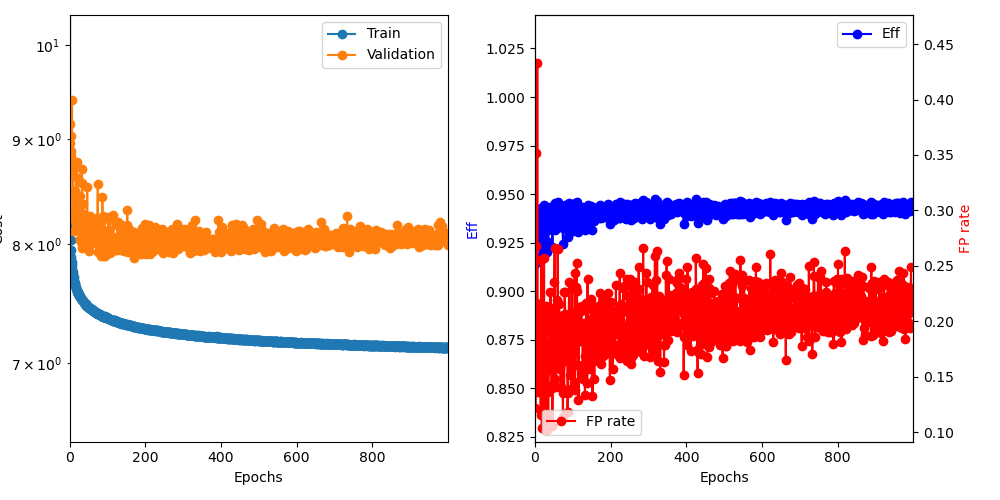

In [11]:
ax, tax, lax, lines = dual_train_plots()
fig = ax.figure
plt.tight_layout()
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)

for model:  UNet_A(
  (block1): ConvBNRelu_A(
    (0): Conv1d(1, 48, kernel_size=(25,), stride=(1,), padding=(12,))
    (1): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (block2): ConvBNRelu_A(
    (0): Conv1d(48, 48, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (block3): ConvBNRelu_A(
    (0): Conv1d(48, 48, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (up1): Up_A(
    (0): ConvTranspose1d(48, 48, kernel_size=(2,), stride=(2,))
    (1): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (up2): Up_A(
    (0): ConvTranspose1d(96, 48, kernel_size=(2,), stride=(2,))
    (1): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Re

/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:95: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 0: train=70.7155, val=8.95704, took 46.325 s
  Validation Found 50455 of 54504, added 2173 (eff 92.57%) (0.218 FP/event)


Epoch 1: train=8.17171, val=9.15214, took 45.783 s
  Validation Found 49814 of 54504, added 1222 (eff 91.40%) (0.122 FP/event)


Epoch 2: train=8.03293, val=8.83555, took 45.849 s
  Validation Found 50879 of 54504, added 2679 (eff 93.35%) (0.268 FP/event)


Epoch 3: train=7.95097, val=9.03168, took 45.829 s
  Validation Found 51248 of 54504, added 3515 (eff 94.03%) (0.352 FP/event)


Epoch 4: train=7.88693, val=8.8857, took 45.801 s
  Validation Found 50339 of 54504, added 1419 (eff 92.36%) (0.142 FP/event)


Epoch 5: train=7.84243, val=8.66711, took 45.727 s
  Validation Found 50383 of 54504, added 1505 (eff 92.44%) (0.151 FP/event)


Epoch 6: train=7.81521, val=9.40594, took 45.745 s
  Validation Found 51357 of 54504, added 4322 (eff 94.23%) (0.433 FP/event)


Epoch 7: train=7.77687, val=8.28246, took 45.698 s
  Validation Found 51081 of 54504, added 2114 (eff 93.72%) (0.212 FP/event)


Epoch 8: train=7.75266, val=8.27249, took 45.692 s
  Validation Found 51003 of 54504, added 1912 (eff 93.58%) (0.191 FP/event)


Epoch 9: train=7.73057, val=8.7224, took 45.776 s
  Validation Found 50393 of 54504, added 1365 (eff 92.46%) (0.137 FP/event)


Epoch 10: train=7.70639, val=8.46401, took 45.717 s
  Validation Found 50492 of 54504, added 1436 (eff 92.64%) (0.144 FP/event)


Epoch 11: train=7.68819, val=8.11988, took 45.911 s
  Validation Found 50833 of 54504, added 1607 (eff 93.26%) (0.161 FP/event)


Epoch 12: train=7.67139, val=8.23038, took 45.748 s
  Validation Found 51187 of 54504, added 2155 (eff 93.91%) (0.216 FP/event)


Epoch 13: train=7.65847, val=8.29038, took 45.739 s
  Validation Found 51070 of 54504, added 2130 (eff 93.70%) (0.213 FP/event)


Epoch 14: train=7.64605, val=8.27019, took 45.708 s
  Validation Found 50890 of 54504, added 1750 (eff 93.37%) (0.175 FP/event)


Epoch 15: train=7.63281, val=8.49648, took 45.682 s
  Validation Found 50299 of 54504, added 1155 (eff 92.28%) (0.116 FP/event)


Epoch 16: train=7.62122, val=8.42801, took 45.711 s
  Validation Found 50607 of 54504, added 1408 (eff 92.85%) (0.141 FP/event)


Epoch 17: train=7.61019, val=8.18254, took 45.666 s
  Validation Found 51394 of 54504, added 2546 (eff 94.29%) (0.255 FP/event)


Epoch 18: train=7.59707, val=8.77355, took 45.721 s
  Validation Found 50079 of 54504, added 1037 (eff 91.88%) (0.104 FP/event)


Epoch 19: train=7.59037, val=8.169, took 45.668 s
  Validation Found 51152 of 54504, added 1973 (eff 93.85%) (0.198 FP/event)


Epoch 20: train=7.58037, val=8.12422, took 45.738 s
  Validation Found 50940 of 54504, added 1693 (eff 93.46%) (0.17 FP/event)


Epoch 21: train=7.57927, val=8.34405, took 45.675 s
  Validation Found 50414 of 54504, added 1214 (eff 92.50%) (0.122 FP/event)


Epoch 22: train=7.56773, val=8.6205, took 45.7 s
  Validation Found 50137 of 54504, added 1043 (eff 91.99%) (0.104 FP/event)


Epoch 23: train=7.5641, val=8.2018, took 45.784 s
  Validation Found 50965 of 54504, added 1808 (eff 93.51%) (0.181 FP/event)


Epoch 24: train=7.56095, val=8.22543, took 45.841 s
  Validation Found 51469 of 54504, added 2567 (eff 94.43%) (0.257 FP/event)


Epoch 25: train=7.55139, val=8.24784, took 45.624 s
  Validation Found 50777 of 54504, added 1402 (eff 93.16%) (0.14 FP/event)


Epoch 26: train=7.54485, val=8.0467, took 45.565 s
  Validation Found 51148 of 54504, added 1806 (eff 93.84%) (0.181 FP/event)


Epoch 27: train=7.54055, val=8.4468, took 45.646 s
  Validation Found 50382 of 54504, added 1147 (eff 92.44%) (0.115 FP/event)


Epoch 28: train=7.53806, val=8.03898, took 45.719 s
  Validation Found 51266 of 54504, added 2041 (eff 94.06%) (0.204 FP/event)


Epoch 29: train=7.53219, val=8.02006, took 45.675 s
  Validation Found 51076 of 54504, added 1778 (eff 93.71%) (0.178 FP/event)


Epoch 30: train=7.52618, val=8.03604, took 45.717 s
  Validation Found 51290 of 54504, added 2137 (eff 94.10%) (0.214 FP/event)


Epoch 31: train=7.52059, val=7.96602, took 45.675 s
  Validation Found 51271 of 54504, added 2038 (eff 94.07%) (0.204 FP/event)


Epoch 32: train=7.5162, val=8.70458, took 45.741 s
  Validation Found 50152 of 54504, added 1017 (eff 92.02%) (0.102 FP/event)


Epoch 33: train=7.51156, val=8.56543, took 45.698 s
  Validation Found 50303 of 54504, added 1086 (eff 92.29%) (0.109 FP/event)


Epoch 34: train=7.50462, val=8.22501, took 45.645 s
  Validation Found 50783 of 54504, added 1360 (eff 93.17%) (0.136 FP/event)


Epoch 35: train=7.5027, val=8.36575, took 45.651 s
  Validation Found 50434 of 54504, added 1157 (eff 92.53%) (0.116 FP/event)


Epoch 36: train=7.50261, val=8.27325, took 45.621 s
  Validation Found 50822 of 54504, added 1416 (eff 93.24%) (0.142 FP/event)


Epoch 37: train=7.49642, val=8.07953, took 45.619 s
  Validation Found 51031 of 54504, added 1653 (eff 93.63%) (0.166 FP/event)


Epoch 38: train=7.48719, val=8.20566, took 45.589 s
  Validation Found 51261 of 54504, added 2128 (eff 94.05%) (0.213 FP/event)


Epoch 39: train=7.485, val=8.1357, took 45.61 s
  Validation Found 50981 of 54504, added 1565 (eff 93.54%) (0.157 FP/event)


Epoch 40: train=7.48251, val=8.25957, took 45.63 s
  Validation Found 50958 of 54504, added 1610 (eff 93.49%) (0.161 FP/event)


Epoch 41: train=7.48278, val=7.99247, took 45.647 s
  Validation Found 51406 of 54504, added 2262 (eff 94.32%) (0.227 FP/event)


Epoch 42: train=7.4761, val=7.97458, took 45.631 s
  Validation Found 51206 of 54504, added 1962 (eff 93.95%) (0.196 FP/event)


Epoch 43: train=7.47612, val=8.10527, took 45.596 s
  Validation Found 51206 of 54504, added 1901 (eff 93.95%) (0.19 FP/event)


Epoch 44: train=7.4664, val=8.16152, took 45.671 s
  Validation Found 50845 of 54504, added 1397 (eff 93.29%) (0.14 FP/event)


Epoch 45: train=7.47033, val=7.9708, took 45.673 s
  Validation Found 51338 of 54504, added 2108 (eff 94.19%) (0.211 FP/event)


Epoch 46: train=7.46411, val=8.5299, took 45.651 s
  Validation Found 50295 of 54504, added 1054 (eff 92.28%) (0.106 FP/event)


Epoch 47: train=7.4587, val=8.10053, took 45.658 s
  Validation Found 51050 of 54504, added 1677 (eff 93.66%) (0.168 FP/event)


Epoch 48: train=7.45488, val=8.08077, took 45.605 s
  Validation Found 51257 of 54504, added 2006 (eff 94.04%) (0.201 FP/event)


Epoch 49: train=7.45259, val=8.12963, took 45.643 s
  Validation Found 51230 of 54504, added 1859 (eff 93.99%) (0.186 FP/event)


Epoch 50: train=7.44893, val=7.93923, took 45.595 s
  Validation Found 51285 of 54504, added 2032 (eff 94.09%) (0.204 FP/event)


Epoch 51: train=7.45237, val=8.23114, took 45.704 s
  Validation Found 51381 of 54504, added 2352 (eff 94.27%) (0.236 FP/event)


Epoch 52: train=7.44423, val=8.21261, took 45.615 s
  Validation Found 51521 of 54504, added 2660 (eff 94.53%) (0.266 FP/event)


Epoch 53: train=7.44591, val=8.25531, took 45.612 s
  Validation Found 50775 of 54504, added 1476 (eff 93.16%) (0.148 FP/event)


Epoch 54: train=7.44069, val=8.08319, took 45.61 s
  Validation Found 51150 of 54504, added 1757 (eff 93.85%) (0.176 FP/event)


Epoch 55: train=7.44152, val=8.09479, took 45.626 s
  Validation Found 51138 of 54504, added 1805 (eff 93.82%) (0.181 FP/event)


Epoch 56: train=7.44009, val=8.17577, took 45.626 s
  Validation Found 50835 of 54504, added 1412 (eff 93.27%) (0.141 FP/event)


Epoch 57: train=7.43474, val=7.9982, took 45.624 s
  Validation Found 51235 of 54504, added 1988 (eff 94.00%) (0.199 FP/event)


Epoch 58: train=7.43409, val=8.05415, took 45.598 s
  Validation Found 51366 of 54504, added 2194 (eff 94.24%) (0.22 FP/event)


Epoch 59: train=7.42817, val=8.08434, took 45.66 s
  Validation Found 51112 of 54504, added 1625 (eff 93.78%) (0.163 FP/event)


Epoch 60: train=7.43038, val=8.1307, took 45.593 s
  Validation Found 51553 of 54504, added 2647 (eff 94.59%) (0.265 FP/event)


Epoch 61: train=7.42651, val=8.11707, took 45.762 s
  Validation Found 51292 of 54504, added 1948 (eff 94.11%) (0.195 FP/event)


Epoch 62: train=7.42289, val=8.03406, took 45.665 s
  Validation Found 51188 of 54504, added 1849 (eff 93.92%) (0.185 FP/event)


Epoch 63: train=7.42444, val=8.0412, took 45.717 s
  Validation Found 51210 of 54504, added 1931 (eff 93.96%) (0.193 FP/event)


Epoch 64: train=7.42197, val=8.11166, took 45.6 s
  Validation Found 51296 of 54504, added 2155 (eff 94.11%) (0.216 FP/event)


Epoch 65: train=7.41645, val=8.18154, took 45.582 s
  Validation Found 51047 of 54504, added 1574 (eff 93.66%) (0.158 FP/event)


Epoch 66: train=7.41595, val=8.09805, took 45.628 s
  Validation Found 51257 of 54504, added 1990 (eff 94.04%) (0.199 FP/event)


Epoch 67: train=7.41577, val=8.0972, took 45.915 s
  Validation Found 51129 of 54504, added 1735 (eff 93.81%) (0.174 FP/event)


Epoch 68: train=7.40928, val=8.1962, took 45.735 s
  Validation Found 50865 of 54504, added 1412 (eff 93.32%) (0.141 FP/event)


Epoch 69: train=7.41242, val=8.01166, took 46.222 s
  Validation Found 51181 of 54504, added 1856 (eff 93.90%) (0.186 FP/event)


Epoch 70: train=7.40631, val=8.12144, took 45.738 s
  Validation Found 51041 of 54504, added 1619 (eff 93.65%) (0.162 FP/event)


Epoch 71: train=7.4046, val=8.02428, took 45.635 s
  Validation Found 51117 of 54504, added 1649 (eff 93.79%) (0.165 FP/event)


Epoch 72: train=7.40059, val=8.03025, took 45.605 s
  Validation Found 51206 of 54504, added 1869 (eff 93.95%) (0.187 FP/event)


Epoch 73: train=7.40836, val=8.2364, took 45.627 s
  Validation Found 50823 of 54504, added 1351 (eff 93.25%) (0.135 FP/event)


Epoch 74: train=7.39838, val=8.56023, took 45.7 s
  Validation Found 50386 of 54504, added 1134 (eff 92.44%) (0.114 FP/event)


Epoch 75: train=7.39758, val=7.92831, took 46.754 s
  Validation Found 51370 of 54504, added 2052 (eff 94.25%) (0.206 FP/event)


Epoch 76: train=7.39936, val=8.12662, took 46.1 s
  Validation Found 51141 of 54504, added 1812 (eff 93.83%) (0.181 FP/event)


Epoch 77: train=7.39374, val=8.15804, took 45.586 s
  Validation Found 50871 of 54504, added 1370 (eff 93.33%) (0.137 FP/event)


Epoch 78: train=7.39351, val=7.98506, took 45.793 s
  Validation Found 51371 of 54504, added 2259 (eff 94.25%) (0.226 FP/event)


Epoch 79: train=7.39256, val=7.92737, took 45.574 s
  Validation Found 51469 of 54504, added 2262 (eff 94.43%) (0.227 FP/event)


Epoch 80: train=7.3897, val=7.99658, took 45.546 s
  Validation Found 51337 of 54504, added 2066 (eff 94.19%) (0.207 FP/event)


Epoch 81: train=7.3877, val=8.03621, took 45.589 s
  Validation Found 51228 of 54504, added 1803 (eff 93.99%) (0.181 FP/event)


Epoch 82: train=7.38297, val=8.13213, took 45.865 s
  Validation Found 51074 of 54504, added 1648 (eff 93.71%) (0.165 FP/event)


Epoch 83: train=7.38815, val=7.89108, took 45.745 s
  Validation Found 51364 of 54504, added 2020 (eff 94.24%) (0.202 FP/event)


Epoch 84: train=7.37853, val=8.00547, took 45.558 s
  Validation Found 51070 of 54504, added 1668 (eff 93.70%) (0.167 FP/event)


Epoch 85: train=7.38414, val=7.95188, took 45.57 s
  Validation Found 51312 of 54504, added 2039 (eff 94.14%) (0.204 FP/event)


Epoch 86: train=7.38114, val=8.43265, took 45.804 s
  Validation Found 50587 of 54504, added 1181 (eff 92.81%) (0.118 FP/event)


Epoch 87: train=7.37518, val=8.2545, took 45.58 s
  Validation Found 50758 of 54504, added 1351 (eff 93.13%) (0.135 FP/event)


Epoch 88: train=7.37566, val=8.00505, took 45.575 s
  Validation Found 51303 of 54504, added 1907 (eff 94.13%) (0.191 FP/event)


Epoch 89: train=7.37237, val=7.97809, took 45.903 s
  Validation Found 51304 of 54504, added 1866 (eff 94.13%) (0.187 FP/event)


Epoch 90: train=7.37603, val=7.891, took 45.866 s
  Validation Found 51528 of 54504, added 2353 (eff 94.54%) (0.236 FP/event)


Epoch 91: train=7.37355, val=7.95451, took 46.047 s
  Validation Found 51287 of 54504, added 1921 (eff 94.10%) (0.192 FP/event)


Epoch 92: train=7.37669, val=8.23819, took 45.567 s
  Validation Found 50980 of 54504, added 1514 (eff 93.53%) (0.152 FP/event)


Epoch 93: train=7.37426, val=8.07482, took 45.87 s
  Validation Found 51171 of 54504, added 1783 (eff 93.88%) (0.179 FP/event)


Epoch 94: train=7.37053, val=7.89244, took 45.654 s
  Validation Found 51288 of 54504, added 1915 (eff 94.10%) (0.192 FP/event)


Epoch 95: train=7.36769, val=8.03214, took 45.768 s
  Validation Found 51143 of 54504, added 1620 (eff 93.83%) (0.162 FP/event)


Epoch 96: train=7.36646, val=7.95898, took 45.632 s
  Validation Found 51351 of 54504, added 1951 (eff 94.22%) (0.195 FP/event)


Epoch 97: train=7.36446, val=8.05095, took 45.58 s
  Validation Found 51486 of 54504, added 2297 (eff 94.46%) (0.23 FP/event)


Epoch 98: train=7.36182, val=7.94623, took 45.83 s
  Validation Found 51306 of 54504, added 2005 (eff 94.13%) (0.201 FP/event)


Epoch 99: train=7.3699, val=8.03743, took 45.813 s
  Validation Found 51089 of 54504, added 1700 (eff 93.73%) (0.17 FP/event)


Epoch 100: train=7.36227, val=8.05367, took 45.871 s
  Validation Found 51086 of 54504, added 1594 (eff 93.73%) (0.16 FP/event)


Epoch 101: train=7.36125, val=8.24481, took 45.67 s
  Validation Found 50747 of 54504, added 1406 (eff 93.11%) (0.141 FP/event)


Epoch 102: train=7.363, val=8.0175, took 45.702 s
  Validation Found 51147 of 54504, added 1742 (eff 93.84%) (0.174 FP/event)


Epoch 103: train=7.35816, val=8.13175, took 45.946 s
  Validation Found 50920 of 54504, added 1451 (eff 93.42%) (0.145 FP/event)


Epoch 104: train=7.35528, val=7.98313, took 45.655 s
  Validation Found 51222 of 54504, added 1817 (eff 93.98%) (0.182 FP/event)


Epoch 105: train=7.35405, val=7.94483, took 45.635 s
  Validation Found 51524 of 54504, added 2429 (eff 94.53%) (0.243 FP/event)


Epoch 106: train=7.3554, val=8.22405, took 45.565 s
  Validation Found 50789 of 54504, added 1379 (eff 93.18%) (0.138 FP/event)


Epoch 107: train=7.35121, val=7.92054, took 45.568 s
  Validation Found 51323 of 54504, added 2084 (eff 94.16%) (0.209 FP/event)


Epoch 108: train=7.34809, val=8.05575, took 45.693 s
  Validation Found 51402 of 54504, added 2306 (eff 94.31%) (0.231 FP/event)


Epoch 109: train=7.34735, val=8.04221, took 45.653 s
  Validation Found 51342 of 54504, added 2021 (eff 94.20%) (0.202 FP/event)


Epoch 110: train=7.34651, val=7.97274, took 45.55 s
  Validation Found 51549 of 54504, added 2527 (eff 94.58%) (0.253 FP/event)


Epoch 111: train=7.3504, val=7.95514, took 45.861 s
  Validation Found 51452 of 54504, added 2268 (eff 94.40%) (0.227 FP/event)


Epoch 112: train=7.34388, val=7.93625, took 46.193 s
  Validation Found 51413 of 54504, added 2083 (eff 94.33%) (0.209 FP/event)


Epoch 113: train=7.34282, val=8.06622, took 45.683 s
  Validation Found 51089 of 54504, added 1605 (eff 93.73%) (0.161 FP/event)


Epoch 114: train=7.34168, val=8.01407, took 45.492 s
  Validation Found 51222 of 54504, added 1890 (eff 93.98%) (0.189 FP/event)


Epoch 115: train=7.34302, val=8.26157, took 45.943 s
  Validation Found 50720 of 54504, added 1287 (eff 93.06%) (0.129 FP/event)


Epoch 116: train=7.34316, val=8.00746, took 45.739 s
  Validation Found 51215 of 54504, added 1825 (eff 93.97%) (0.183 FP/event)


Epoch 117: train=7.34416, val=7.98152, took 45.478 s
  Validation Found 51403 of 54504, added 2129 (eff 94.31%) (0.213 FP/event)


Epoch 118: train=7.34209, val=8.02647, took 45.587 s
  Validation Found 51230 of 54504, added 1824 (eff 93.99%) (0.183 FP/event)


Epoch 119: train=7.34384, val=7.94885, took 46.42 s
  Validation Found 51409 of 54504, added 2122 (eff 94.32%) (0.213 FP/event)


Epoch 120: train=7.33575, val=7.97652, took 45.512 s
  Validation Found 51250 of 54504, added 1957 (eff 94.03%) (0.196 FP/event)


Epoch 121: train=7.3373, val=7.95563, took 45.76 s
  Validation Found 51323 of 54504, added 1986 (eff 94.16%) (0.199 FP/event)


Epoch 122: train=7.33738, val=7.98568, took 45.62 s
  Validation Found 51369 of 54504, added 2093 (eff 94.25%) (0.21 FP/event)


Epoch 123: train=7.33062, val=7.99524, took 45.515 s
  Validation Found 51407 of 54504, added 2135 (eff 94.32%) (0.214 FP/event)


Epoch 124: train=7.33566, val=7.99407, took 45.544 s
  Validation Found 51297 of 54504, added 1917 (eff 94.12%) (0.192 FP/event)


Epoch 125: train=7.33223, val=7.95183, took 45.955 s
  Validation Found 51301 of 54504, added 1912 (eff 94.12%) (0.191 FP/event)


Epoch 126: train=7.33074, val=8.17266, took 46.582 s
  Validation Found 50911 of 54504, added 1480 (eff 93.41%) (0.148 FP/event)


Epoch 127: train=7.33318, val=8.05328, took 45.982 s
  Validation Found 51099 of 54504, added 1610 (eff 93.75%) (0.161 FP/event)


Epoch 128: train=7.32961, val=8.19847, took 45.577 s
  Validation Found 50950 of 54504, added 1543 (eff 93.48%) (0.155 FP/event)


Epoch 129: train=7.32801, val=7.99951, took 45.551 s
  Validation Found 51341 of 54504, added 1980 (eff 94.20%) (0.198 FP/event)


Epoch 130: train=7.32907, val=8.02287, took 45.598 s
  Validation Found 51327 of 54504, added 1964 (eff 94.17%) (0.197 FP/event)


Epoch 131: train=7.32297, val=8.02292, took 45.677 s
  Validation Found 51181 of 54504, added 1690 (eff 93.90%) (0.169 FP/event)


Epoch 132: train=7.32369, val=8.18657, took 45.646 s
  Validation Found 50785 of 54504, added 1333 (eff 93.18%) (0.134 FP/event)


Epoch 133: train=7.32303, val=7.96125, took 45.948 s
  Validation Found 51269 of 54504, added 1862 (eff 94.06%) (0.186 FP/event)


Epoch 134: train=7.32379, val=8.15138, took 45.577 s
  Validation Found 51051 of 54504, added 1632 (eff 93.66%) (0.163 FP/event)


Epoch 135: train=7.32346, val=7.94599, took 45.587 s
  Validation Found 51430 of 54504, added 2159 (eff 94.36%) (0.216 FP/event)


Epoch 136: train=7.31806, val=8.05354, took 45.658 s
  Validation Found 51408 of 54504, added 2152 (eff 94.32%) (0.216 FP/event)


Epoch 137: train=7.31988, val=7.95779, took 46.575 s
  Validation Found 51361 of 54504, added 2107 (eff 94.23%) (0.211 FP/event)


Epoch 138: train=7.31985, val=8.10339, took 46.012 s
  Validation Found 50952 of 54504, added 1448 (eff 93.48%) (0.145 FP/event)


Epoch 139: train=7.31879, val=8.02052, took 45.531 s
  Validation Found 51481 of 54504, added 2379 (eff 94.45%) (0.238 FP/event)


Epoch 140: train=7.31617, val=8.13048, took 45.542 s
  Validation Found 51054 of 54504, added 1631 (eff 93.67%) (0.163 FP/event)


Epoch 141: train=7.32289, val=8.07896, took 45.512 s
  Validation Found 51108 of 54504, added 1765 (eff 93.77%) (0.177 FP/event)


Epoch 142: train=7.31584, val=8.04437, took 45.814 s
  Validation Found 51157 of 54504, added 1717 (eff 93.86%) (0.172 FP/event)


Epoch 143: train=7.31427, val=7.94141, took 45.706 s
  Validation Found 51336 of 54504, added 1975 (eff 94.19%) (0.198 FP/event)


Epoch 144: train=7.3134, val=8.06129, took 45.575 s
  Validation Found 51162 of 54504, added 1738 (eff 93.87%) (0.174 FP/event)


Epoch 145: train=7.31179, val=8.09265, took 45.722 s
  Validation Found 51061 of 54504, added 1566 (eff 93.68%) (0.157 FP/event)


Epoch 146: train=7.31423, val=8.02502, took 45.54 s
  Validation Found 51216 of 54504, added 1786 (eff 93.97%) (0.179 FP/event)


Epoch 147: train=7.31633, val=8.05963, took 45.545 s
  Validation Found 51267 of 54504, added 2020 (eff 94.06%) (0.202 FP/event)


Epoch 148: train=7.30918, val=7.93456, took 46.024 s
  Validation Found 51420 of 54504, added 2198 (eff 94.34%) (0.22 FP/event)


Epoch 149: train=7.31319, val=7.96013, took 45.532 s
  Validation Found 51459 of 54504, added 2176 (eff 94.41%) (0.218 FP/event)


Epoch 150: train=7.30636, val=7.94448, took 45.523 s
  Validation Found 51384 of 54504, added 2117 (eff 94.28%) (0.212 FP/event)


Epoch 151: train=7.3063, val=8.17593, took 46.124 s
  Validation Found 51068 of 54504, added 1736 (eff 93.70%) (0.174 FP/event)


Epoch 152: train=7.31037, val=8.31446, took 45.643 s
  Validation Found 50760 of 54504, added 1331 (eff 93.13%) (0.133 FP/event)


Epoch 153: train=7.30908, val=7.99275, took 45.509 s
  Validation Found 51311 of 54504, added 1883 (eff 94.14%) (0.189 FP/event)


Epoch 154: train=7.30629, val=7.92851, took 45.697 s
  Validation Found 51343 of 54504, added 1997 (eff 94.20%) (0.2 FP/event)


Epoch 155: train=7.30418, val=8.11947, took 45.736 s
  Validation Found 51149 of 54504, added 1697 (eff 93.84%) (0.17 FP/event)


Epoch 156: train=7.30733, val=8.11014, took 45.566 s
  Validation Found 51138 of 54504, added 1642 (eff 93.82%) (0.164 FP/event)


Epoch 157: train=7.30422, val=8.13869, took 45.767 s
  Validation Found 51012 of 54504, added 1482 (eff 93.59%) (0.148 FP/event)


Epoch 158: train=7.30415, val=7.95307, took 45.508 s
  Validation Found 51378 of 54504, added 2048 (eff 94.26%) (0.205 FP/event)


Epoch 159: train=7.30394, val=8.12221, took 45.785 s
  Validation Found 51086 of 54504, added 1741 (eff 93.73%) (0.174 FP/event)


Epoch 160: train=7.30223, val=7.99661, took 45.565 s
  Validation Found 51276 of 54504, added 2007 (eff 94.08%) (0.201 FP/event)


Epoch 161: train=7.30214, val=8.02882, took 45.569 s
  Validation Found 51314 of 54504, added 2010 (eff 94.15%) (0.201 FP/event)


Epoch 162: train=7.30124, val=8.00854, took 45.65 s
  Validation Found 51334 of 54504, added 2115 (eff 94.18%) (0.212 FP/event)


Epoch 163: train=7.30016, val=8.02511, took 45.54 s
  Validation Found 51369 of 54504, added 2067 (eff 94.25%) (0.207 FP/event)


Epoch 164: train=7.29868, val=7.99861, took 45.494 s
  Validation Found 51325 of 54504, added 2029 (eff 94.17%) (0.203 FP/event)


Epoch 165: train=7.29512, val=8.01429, took 45.528 s
  Validation Found 51145 of 54504, added 1702 (eff 93.84%) (0.17 FP/event)


Epoch 166: train=7.29619, val=7.97465, took 45.642 s
  Validation Found 51350 of 54504, added 2054 (eff 94.21%) (0.206 FP/event)


Epoch 167: train=7.29394, val=7.94175, took 45.585 s
  Validation Found 51409 of 54504, added 2114 (eff 94.32%) (0.212 FP/event)


Epoch 168: train=7.29161, val=8.0055, took 45.646 s
  Validation Found 51326 of 54504, added 2091 (eff 94.17%) (0.209 FP/event)


Epoch 169: train=7.2945, val=8.10817, took 45.471 s
  Validation Found 51103 of 54504, added 1666 (eff 93.76%) (0.167 FP/event)


Epoch 170: train=7.29205, val=7.9709, took 45.733 s
  Validation Found 51349 of 54504, added 2017 (eff 94.21%) (0.202 FP/event)


Epoch 171: train=7.29695, val=7.87985, took 45.583 s
  Validation Found 51463 of 54504, added 2255 (eff 94.42%) (0.226 FP/event)


Epoch 172: train=7.28978, val=8.10306, took 45.69 s
  Validation Found 51272 of 54504, added 1907 (eff 94.07%) (0.191 FP/event)


Epoch 173: train=7.29202, val=8.03759, took 45.545 s
  Validation Found 51345 of 54504, added 2142 (eff 94.20%) (0.215 FP/event)


Epoch 174: train=7.29138, val=8.09024, took 45.672 s
  Validation Found 51187 of 54504, added 1761 (eff 93.91%) (0.176 FP/event)


Epoch 175: train=7.29123, val=8.06416, took 45.972 s
  Validation Found 51110 of 54504, added 1619 (eff 93.77%) (0.162 FP/event)


Epoch 176: train=7.28937, val=8.0719, took 45.534 s
  Validation Found 51182 of 54504, added 1851 (eff 93.91%) (0.185 FP/event)


Epoch 177: train=7.29192, val=7.97141, took 45.541 s
  Validation Found 51350 of 54504, added 1970 (eff 94.21%) (0.197 FP/event)


Epoch 178: train=7.28809, val=7.99373, took 45.521 s
  Validation Found 51339 of 54504, added 1988 (eff 94.19%) (0.199 FP/event)


Epoch 179: train=7.2875, val=7.93212, took 45.583 s
  Validation Found 51415 of 54504, added 2063 (eff 94.33%) (0.207 FP/event)


Epoch 180: train=7.28502, val=7.94862, took 45.715 s
  Validation Found 51428 of 54504, added 2201 (eff 94.36%) (0.22 FP/event)


Epoch 181: train=7.28583, val=8.08892, took 46.44 s
  Validation Found 51136 of 54504, added 1684 (eff 93.82%) (0.169 FP/event)


Epoch 182: train=7.28434, val=7.99468, took 46.5 s
  Validation Found 51341 of 54504, added 2092 (eff 94.20%) (0.21 FP/event)


Epoch 183: train=7.2897, val=7.98902, took 45.614 s
  Validation Found 51428 of 54504, added 2138 (eff 94.36%) (0.214 FP/event)


Epoch 184: train=7.28531, val=8.08511, took 45.622 s
  Validation Found 51136 of 54504, added 1708 (eff 93.82%) (0.171 FP/event)


Epoch 185: train=7.28459, val=8.07447, took 45.564 s
  Validation Found 51189 of 54504, added 1944 (eff 93.92%) (0.195 FP/event)


Epoch 186: train=7.28184, val=7.95497, took 45.497 s
  Validation Found 51388 of 54504, added 2220 (eff 94.28%) (0.222 FP/event)


Epoch 187: train=7.28446, val=8.00371, took 45.825 s
  Validation Found 51304 of 54504, added 1880 (eff 94.13%) (0.188 FP/event)


Epoch 188: train=7.28228, val=7.98079, took 45.539 s
  Validation Found 51300 of 54504, added 1928 (eff 94.12%) (0.193 FP/event)


Epoch 189: train=7.27968, val=7.90824, took 45.919 s
  Validation Found 51365 of 54504, added 2049 (eff 94.24%) (0.205 FP/event)


Epoch 190: train=7.28416, val=8.14312, took 45.544 s
  Validation Found 51127 of 54504, added 1778 (eff 93.80%) (0.178 FP/event)


Epoch 191: train=7.28147, val=8.02206, took 46.175 s
  Validation Found 51291 of 54504, added 1862 (eff 94.11%) (0.186 FP/event)


Epoch 192: train=7.27816, val=7.93111, took 45.772 s
  Validation Found 51489 of 54504, added 2257 (eff 94.47%) (0.226 FP/event)


Epoch 193: train=7.27984, val=7.9562, took 45.476 s
  Validation Found 51331 of 54504, added 1897 (eff 94.18%) (0.19 FP/event)


Epoch 194: train=7.27758, val=8.01111, took 45.552 s
  Validation Found 51391 of 54504, added 2090 (eff 94.29%) (0.209 FP/event)


Epoch 195: train=7.27728, val=8.12773, took 45.617 s
  Validation Found 51230 of 54504, added 1815 (eff 93.99%) (0.182 FP/event)


Epoch 196: train=7.27665, val=8.02385, took 45.848 s
  Validation Found 51236 of 54504, added 1758 (eff 94.00%) (0.176 FP/event)


Epoch 197: train=7.27706, val=8.0487, took 46.422 s
  Validation Found 51273 of 54504, added 1911 (eff 94.07%) (0.191 FP/event)


Epoch 198: train=7.27413, val=8.18112, took 45.593 s
  Validation Found 50947 of 54504, added 1469 (eff 93.47%) (0.147 FP/event)


Epoch 199: train=7.2758, val=7.95061, took 45.548 s
  Validation Found 51401 of 54504, added 2104 (eff 94.31%) (0.211 FP/event)


Epoch 200: train=7.27489, val=7.96755, took 45.529 s
  Validation Found 51418 of 54504, added 2173 (eff 94.34%) (0.218 FP/event)


Epoch 201: train=7.27518, val=7.91461, took 45.574 s
  Validation Found 51378 of 54504, added 2099 (eff 94.26%) (0.21 FP/event)


Epoch 202: train=7.27711, val=7.95476, took 45.559 s
  Validation Found 51371 of 54504, added 1980 (eff 94.25%) (0.198 FP/event)


Epoch 203: train=7.27104, val=7.96435, took 45.562 s
  Validation Found 51287 of 54504, added 1872 (eff 94.10%) (0.187 FP/event)


Epoch 204: train=7.27307, val=8.02285, took 45.815 s
  Validation Found 51267 of 54504, added 1884 (eff 94.06%) (0.189 FP/event)


Epoch 205: train=7.27319, val=8.10004, took 45.904 s
  Validation Found 51046 of 54504, added 1568 (eff 93.66%) (0.157 FP/event)


Epoch 206: train=7.26796, val=8.04109, took 45.641 s
  Validation Found 51154 of 54504, added 1724 (eff 93.85%) (0.173 FP/event)


Epoch 207: train=7.27188, val=8.06708, took 45.6 s
  Validation Found 51177 of 54504, added 1712 (eff 93.90%) (0.171 FP/event)


Epoch 208: train=7.27011, val=8.01285, took 45.497 s
  Validation Found 51255 of 54504, added 1900 (eff 94.04%) (0.19 FP/event)


Epoch 209: train=7.27068, val=8.17545, took 46.129 s
  Validation Found 51055 of 54504, added 1713 (eff 93.67%) (0.172 FP/event)


Epoch 210: train=7.26859, val=8.01744, took 45.595 s
  Validation Found 51328 of 54504, added 1890 (eff 94.17%) (0.189 FP/event)


Epoch 211: train=7.26718, val=7.9854, took 45.564 s
  Validation Found 51366 of 54504, added 2058 (eff 94.24%) (0.206 FP/event)


Epoch 212: train=7.26781, val=8.04339, took 45.529 s
  Validation Found 51184 of 54504, added 1782 (eff 93.91%) (0.178 FP/event)


Epoch 213: train=7.27029, val=7.90998, took 45.519 s
  Validation Found 51345 of 54504, added 2027 (eff 94.20%) (0.203 FP/event)


Epoch 214: train=7.26538, val=8.03076, took 45.63 s
  Validation Found 51489 of 54504, added 2323 (eff 94.47%) (0.233 FP/event)


Epoch 215: train=7.26645, val=7.98829, took 45.626 s
  Validation Found 51284 of 54504, added 1884 (eff 94.09%) (0.189 FP/event)


Epoch 216: train=7.26541, val=8.0064, took 45.844 s
  Validation Found 51356 of 54504, added 2079 (eff 94.22%) (0.208 FP/event)


Epoch 217: train=7.26832, val=8.01261, took 45.744 s
  Validation Found 51277 of 54504, added 1955 (eff 94.08%) (0.196 FP/event)


Epoch 218: train=7.26407, val=8.00598, took 45.64 s
  Validation Found 51376 of 54504, added 2010 (eff 94.26%) (0.201 FP/event)


Epoch 219: train=7.2625, val=8.02743, took 45.573 s
  Validation Found 51328 of 54504, added 1975 (eff 94.17%) (0.198 FP/event)


Epoch 220: train=7.26226, val=7.93811, took 45.528 s
  Validation Found 51371 of 54504, added 2035 (eff 94.25%) (0.204 FP/event)


Epoch 221: train=7.26388, val=8.09217, took 45.865 s
  Validation Found 51117 of 54504, added 1689 (eff 93.79%) (0.169 FP/event)


Epoch 222: train=7.26196, val=8.10184, took 45.549 s
  Validation Found 51188 of 54504, added 1771 (eff 93.92%) (0.177 FP/event)


Epoch 223: train=7.2619, val=8.0804, took 45.659 s
  Validation Found 51350 of 54504, added 2122 (eff 94.21%) (0.213 FP/event)


Epoch 224: train=7.26563, val=7.95519, took 45.562 s
  Validation Found 51554 of 54504, added 2431 (eff 94.59%) (0.243 FP/event)


Epoch 225: train=7.26029, val=8.00367, took 45.501 s
  Validation Found 51305 of 54504, added 2009 (eff 94.13%) (0.201 FP/event)


Epoch 226: train=7.2626, val=8.15158, took 45.508 s
  Validation Found 51115 of 54504, added 1668 (eff 93.78%) (0.167 FP/event)


Epoch 227: train=7.26196, val=8.06215, took 45.74 s
  Validation Found 51125 of 54504, added 1679 (eff 93.80%) (0.168 FP/event)


Epoch 228: train=7.26388, val=8.02998, took 45.794 s
  Validation Found 51335 of 54504, added 2150 (eff 94.19%) (0.215 FP/event)


Epoch 229: train=7.26436, val=8.05473, took 45.675 s
  Validation Found 51146 of 54504, added 1714 (eff 93.84%) (0.172 FP/event)


Epoch 230: train=7.26161, val=7.98467, took 45.626 s
  Validation Found 51406 of 54504, added 2081 (eff 94.32%) (0.208 FP/event)


Epoch 231: train=7.25645, val=7.98517, took 45.563 s
  Validation Found 51418 of 54504, added 2126 (eff 94.34%) (0.213 FP/event)


Epoch 232: train=7.25953, val=8.00575, took 45.62 s
  Validation Found 51278 of 54504, added 1845 (eff 94.08%) (0.185 FP/event)


Epoch 233: train=7.25525, val=7.96615, took 45.83 s
  Validation Found 51490 of 54504, added 2294 (eff 94.47%) (0.23 FP/event)


Epoch 234: train=7.26181, val=8.03131, took 45.687 s
  Validation Found 51279 of 54504, added 1902 (eff 94.08%) (0.19 FP/event)


Epoch 235: train=7.25476, val=7.9579, took 45.608 s
  Validation Found 51497 of 54504, added 2312 (eff 94.48%) (0.232 FP/event)


Epoch 236: train=7.25773, val=8.06586, took 45.693 s
  Validation Found 51277 of 54504, added 1949 (eff 94.08%) (0.195 FP/event)


Epoch 237: train=7.25445, val=8.0266, took 45.571 s
  Validation Found 51238 of 54504, added 1824 (eff 94.01%) (0.183 FP/event)


Epoch 238: train=7.25779, val=8.11295, took 45.944 s
  Validation Found 51133 of 54504, added 1665 (eff 93.82%) (0.167 FP/event)


Epoch 239: train=7.25936, val=7.99463, took 45.989 s
  Validation Found 51280 of 54504, added 1923 (eff 94.08%) (0.193 FP/event)


Epoch 240: train=7.25425, val=8.08884, took 45.846 s
  Validation Found 51093 of 54504, added 1667 (eff 93.74%) (0.167 FP/event)


Epoch 241: train=7.25134, val=7.98684, took 45.695 s
  Validation Found 51283 of 54504, added 1960 (eff 94.09%) (0.196 FP/event)


Epoch 242: train=7.25335, val=8.06248, took 45.607 s
  Validation Found 51262 of 54504, added 1890 (eff 94.05%) (0.189 FP/event)


Epoch 243: train=7.25062, val=8.10067, took 45.515 s
  Validation Found 51103 of 54504, added 1643 (eff 93.76%) (0.165 FP/event)


Epoch 244: train=7.2541, val=7.93465, took 45.711 s
  Validation Found 51499 of 54504, added 2383 (eff 94.49%) (0.239 FP/event)


Epoch 245: train=7.24955, val=8.13872, took 45.768 s
  Validation Found 51120 of 54504, added 1723 (eff 93.79%) (0.173 FP/event)


Epoch 246: train=7.24876, val=8.06901, took 45.667 s
  Validation Found 51172 of 54504, added 1794 (eff 93.89%) (0.18 FP/event)


Epoch 247: train=7.25118, val=7.92029, took 45.497 s
  Validation Found 51456 of 54504, added 2226 (eff 94.41%) (0.223 FP/event)


Epoch 248: train=7.2526, val=8.08878, took 45.458 s
  Validation Found 51095 of 54504, added 1705 (eff 93.75%) (0.171 FP/event)


Epoch 249: train=7.25055, val=7.99818, took 46.293 s
  Validation Found 51457 of 54504, added 2220 (eff 94.41%) (0.222 FP/event)


Epoch 250: train=7.25027, val=7.96684, took 46.321 s
  Validation Found 51348 of 54504, added 2009 (eff 94.21%) (0.201 FP/event)


Epoch 251: train=7.25082, val=8.02533, took 45.525 s
  Validation Found 51321 of 54504, added 2005 (eff 94.16%) (0.201 FP/event)


Epoch 252: train=7.24849, val=8.00798, took 45.451 s
  Validation Found 51478 of 54504, added 2382 (eff 94.45%) (0.239 FP/event)


Epoch 253: train=7.24494, val=8.03201, took 45.462 s
  Validation Found 51149 of 54504, added 1668 (eff 93.84%) (0.167 FP/event)


Epoch 254: train=7.24814, val=8.06464, took 45.468 s
  Validation Found 51320 of 54504, added 1987 (eff 94.16%) (0.199 FP/event)


Epoch 255: train=7.24641, val=8.10732, took 45.524 s
  Validation Found 51064 of 54504, added 1617 (eff 93.69%) (0.162 FP/event)


Epoch 256: train=7.24762, val=7.95549, took 45.442 s
  Validation Found 51477 of 54504, added 2308 (eff 94.45%) (0.231 FP/event)


Epoch 257: train=7.24867, val=7.98925, took 45.434 s
  Validation Found 51438 of 54504, added 2215 (eff 94.37%) (0.222 FP/event)


Epoch 258: train=7.24558, val=8.0262, took 46.152 s
  Validation Found 51284 of 54504, added 1932 (eff 94.09%) (0.193 FP/event)


Epoch 259: train=7.24626, val=7.98391, took 45.503 s
  Validation Found 51344 of 54504, added 1993 (eff 94.20%) (0.2 FP/event)


Epoch 260: train=7.24642, val=8.10659, took 45.974 s
  Validation Found 51097 of 54504, added 1692 (eff 93.75%) (0.169 FP/event)


Epoch 261: train=7.24785, val=7.97508, took 45.962 s
  Validation Found 51388 of 54504, added 2050 (eff 94.28%) (0.205 FP/event)


Epoch 262: train=7.24565, val=7.93162, took 45.663 s
  Validation Found 51493 of 54504, added 2323 (eff 94.48%) (0.233 FP/event)


Epoch 263: train=7.24283, val=8.07474, took 45.439 s
  Validation Found 51118 of 54504, added 1739 (eff 93.79%) (0.174 FP/event)


Epoch 264: train=7.24473, val=7.96011, took 45.582 s
  Validation Found 51378 of 54504, added 2094 (eff 94.26%) (0.21 FP/event)


Epoch 265: train=7.24665, val=8.01764, took 45.484 s
  Validation Found 51520 of 54504, added 2349 (eff 94.53%) (0.235 FP/event)


Epoch 266: train=7.24343, val=8.09632, took 45.445 s
  Validation Found 51166 of 54504, added 1781 (eff 93.88%) (0.178 FP/event)


Epoch 267: train=7.24278, val=8.0598, took 45.697 s
  Validation Found 51184 of 54504, added 1749 (eff 93.91%) (0.175 FP/event)


Epoch 268: train=7.24191, val=7.93463, took 45.463 s
  Validation Found 51481 of 54504, added 2233 (eff 94.45%) (0.224 FP/event)


Epoch 269: train=7.24003, val=8.02398, took 45.515 s
  Validation Found 51234 of 54504, added 1793 (eff 94.00%) (0.18 FP/event)


Epoch 270: train=7.2432, val=8.04159, took 45.478 s
  Validation Found 51377 of 54504, added 2093 (eff 94.26%) (0.21 FP/event)


Epoch 271: train=7.24152, val=8.13321, took 45.451 s
  Validation Found 51235 of 54504, added 1861 (eff 94.00%) (0.186 FP/event)


Epoch 272: train=7.23892, val=8.01375, took 45.69 s
  Validation Found 51223 of 54504, added 1821 (eff 93.98%) (0.182 FP/event)


Epoch 273: train=7.23949, val=8.01212, took 45.563 s
  Validation Found 51384 of 54504, added 2053 (eff 94.28%) (0.206 FP/event)


Epoch 274: train=7.23917, val=7.92402, took 45.535 s
  Validation Found 51542 of 54504, added 2490 (eff 94.57%) (0.249 FP/event)


Epoch 275: train=7.24087, val=7.96165, took 45.489 s
  Validation Found 51495 of 54504, added 2293 (eff 94.48%) (0.23 FP/event)


Epoch 276: train=7.23974, val=7.99472, took 45.523 s
  Validation Found 51408 of 54504, added 2108 (eff 94.32%) (0.211 FP/event)


Epoch 277: train=7.23996, val=8.10501, took 45.689 s
  Validation Found 51194 of 54504, added 1760 (eff 93.93%) (0.176 FP/event)


Epoch 278: train=7.24206, val=7.95273, took 45.375 s
  Validation Found 51424 of 54504, added 2139 (eff 94.35%) (0.214 FP/event)


Epoch 279: train=7.23757, val=8.06815, took 45.746 s
  Validation Found 51216 of 54504, added 1790 (eff 93.97%) (0.179 FP/event)


Epoch 280: train=7.23959, val=8.07308, took 45.657 s
  Validation Found 51195 of 54504, added 1718 (eff 93.93%) (0.172 FP/event)


Epoch 281: train=7.23519, val=7.98167, took 45.399 s
  Validation Found 51451 of 54504, added 2197 (eff 94.40%) (0.22 FP/event)


Epoch 282: train=7.23651, val=8.01787, took 45.703 s
  Validation Found 51366 of 54504, added 2069 (eff 94.24%) (0.207 FP/event)


Epoch 283: train=7.23666, val=8.01552, took 45.508 s
  Validation Found 51268 of 54504, added 1938 (eff 94.06%) (0.194 FP/event)


Epoch 284: train=7.23885, val=8.18665, took 45.557 s
  Validation Found 51072 of 54504, added 1745 (eff 93.70%) (0.175 FP/event)


Epoch 285: train=7.23634, val=8.0201, took 45.436 s
  Validation Found 51394 of 54504, added 2131 (eff 94.29%) (0.213 FP/event)


Epoch 286: train=7.23169, val=7.96043, took 45.491 s
  Validation Found 51603 of 54504, added 2660 (eff 94.68%) (0.266 FP/event)


Epoch 287: train=7.23645, val=8.12594, took 45.442 s
  Validation Found 51208 of 54504, added 1892 (eff 93.95%) (0.189 FP/event)


Epoch 288: train=7.23445, val=8.00633, took 45.469 s
  Validation Found 51253 of 54504, added 1881 (eff 94.04%) (0.188 FP/event)


Epoch 289: train=7.23455, val=8.05664, took 45.464 s
  Validation Found 51175 of 54504, added 1687 (eff 93.89%) (0.169 FP/event)


Epoch 290: train=7.23935, val=8.02328, took 45.953 s
  Validation Found 51264 of 54504, added 1841 (eff 94.06%) (0.184 FP/event)


Epoch 291: train=7.23239, val=8.04375, took 45.429 s
  Validation Found 51331 of 54504, added 1969 (eff 94.18%) (0.197 FP/event)


Epoch 292: train=7.23344, val=8.02529, took 45.503 s
  Validation Found 51283 of 54504, added 1903 (eff 94.09%) (0.191 FP/event)


Epoch 293: train=7.23183, val=8.13452, took 45.446 s
  Validation Found 51342 of 54504, added 2043 (eff 94.20%) (0.205 FP/event)


Epoch 294: train=7.23289, val=7.99415, took 45.618 s
  Validation Found 51552 of 54504, added 2433 (eff 94.58%) (0.244 FP/event)


Epoch 295: train=7.23335, val=7.98601, took 45.661 s
  Validation Found 51493 of 54504, added 2350 (eff 94.48%) (0.235 FP/event)


Epoch 296: train=7.23032, val=8.13156, took 46.565 s
  Validation Found 51225 of 54504, added 1916 (eff 93.98%) (0.192 FP/event)


Epoch 297: train=7.23137, val=8.04451, took 46.522 s
  Validation Found 51278 of 54504, added 1896 (eff 94.08%) (0.19 FP/event)


Epoch 298: train=7.23305, val=8.07138, took 46.572 s
  Validation Found 51164 of 54504, added 1793 (eff 93.87%) (0.18 FP/event)


Epoch 299: train=7.23019, val=7.97887, took 45.58 s
  Validation Found 51363 of 54504, added 1990 (eff 94.24%) (0.199 FP/event)


Epoch 300: train=7.23208, val=8.00192, took 45.491 s
  Validation Found 51422 of 54504, added 2151 (eff 94.35%) (0.215 FP/event)


Epoch 301: train=7.22858, val=8.04727, took 45.622 s
  Validation Found 51311 of 54504, added 1987 (eff 94.14%) (0.199 FP/event)


Epoch 302: train=7.23057, val=8.02097, took 45.616 s
  Validation Found 51444 of 54504, added 2167 (eff 94.39%) (0.217 FP/event)


Epoch 303: train=7.22987, val=8.13551, took 46.133 s
  Validation Found 51090 of 54504, added 1674 (eff 93.74%) (0.168 FP/event)


Epoch 304: train=7.23083, val=7.9968, took 46.148 s
  Validation Found 51251 of 54504, added 1797 (eff 94.03%) (0.18 FP/event)


Epoch 305: train=7.22973, val=8.02933, took 45.562 s
  Validation Found 51344 of 54504, added 2021 (eff 94.20%) (0.202 FP/event)


Epoch 306: train=7.22961, val=8.07258, took 45.444 s
  Validation Found 51236 of 54504, added 1894 (eff 94.00%) (0.19 FP/event)


Epoch 307: train=7.22797, val=8.06866, took 45.658 s
  Validation Found 51480 of 54504, added 2221 (eff 94.45%) (0.222 FP/event)


Epoch 308: train=7.22872, val=8.10922, took 45.622 s
  Validation Found 51151 of 54504, added 1757 (eff 93.85%) (0.176 FP/event)


Epoch 309: train=7.22761, val=7.9789, took 45.673 s
  Validation Found 51429 of 54504, added 2165 (eff 94.36%) (0.217 FP/event)


Epoch 310: train=7.22794, val=8.08645, took 45.592 s
  Validation Found 51406 of 54504, added 2187 (eff 94.32%) (0.219 FP/event)


Epoch 311: train=7.22596, val=7.97047, took 45.576 s
  Validation Found 51505 of 54504, added 2322 (eff 94.50%) (0.233 FP/event)


Epoch 312: train=7.22463, val=8.00094, took 45.891 s
  Validation Found 51315 of 54504, added 1944 (eff 94.15%) (0.195 FP/event)


Epoch 313: train=7.22566, val=8.06256, took 46.033 s
  Validation Found 51169 of 54504, added 1735 (eff 93.88%) (0.174 FP/event)


Epoch 314: train=7.22686, val=8.14003, took 45.736 s
  Validation Found 51212 of 54504, added 1941 (eff 93.96%) (0.194 FP/event)


Epoch 315: train=7.22382, val=8.00863, took 45.746 s
  Validation Found 51330 of 54504, added 2039 (eff 94.18%) (0.204 FP/event)


Epoch 316: train=7.22468, val=7.97966, took 45.581 s
  Validation Found 51396 of 54504, added 2091 (eff 94.30%) (0.209 FP/event)


Epoch 317: train=7.22314, val=7.91825, took 45.913 s
  Validation Found 51642 of 54504, added 2588 (eff 94.75%) (0.259 FP/event)


Epoch 318: train=7.22332, val=8.12955, took 45.448 s
  Validation Found 51142 of 54504, added 1705 (eff 93.83%) (0.171 FP/event)


Epoch 319: train=7.22237, val=7.98085, took 45.737 s
  Validation Found 51296 of 54504, added 1874 (eff 94.11%) (0.188 FP/event)


Epoch 320: train=7.22338, val=8.04787, took 45.458 s
  Validation Found 51334 of 54504, added 1985 (eff 94.18%) (0.199 FP/event)


Epoch 321: train=7.22336, val=7.98029, took 45.439 s
  Validation Found 51509 of 54504, added 2368 (eff 94.50%) (0.237 FP/event)


Epoch 322: train=7.22224, val=7.96084, took 45.821 s
  Validation Found 51452 of 54504, added 2216 (eff 94.40%) (0.222 FP/event)


Epoch 323: train=7.22048, val=7.98548, took 45.523 s
  Validation Found 51591 of 54504, added 2635 (eff 94.66%) (0.264 FP/event)


Epoch 324: train=7.22221, val=8.17789, took 45.393 s
  Validation Found 51106 of 54504, added 1639 (eff 93.77%) (0.164 FP/event)


Epoch 325: train=7.22204, val=8.09694, took 45.395 s
  Validation Found 51242 of 54504, added 1863 (eff 94.02%) (0.187 FP/event)


Epoch 326: train=7.2205, val=8.06811, took 45.395 s
  Validation Found 51278 of 54504, added 1926 (eff 94.08%) (0.193 FP/event)


Epoch 327: train=7.22382, val=7.94012, took 45.458 s
  Validation Found 51407 of 54504, added 2121 (eff 94.32%) (0.212 FP/event)


Epoch 328: train=7.21907, val=7.97482, took 45.608 s
  Validation Found 51467 of 54504, added 2225 (eff 94.43%) (0.223 FP/event)


Epoch 329: train=7.22244, val=8.04191, took 45.567 s
  Validation Found 51242 of 54504, added 1907 (eff 94.02%) (0.191 FP/event)


Epoch 330: train=7.2203, val=7.97234, took 45.452 s
  Validation Found 51346 of 54504, added 2056 (eff 94.21%) (0.206 FP/event)


Epoch 331: train=7.21915, val=8.22256, took 45.563 s
  Validation Found 50955 of 54504, added 1539 (eff 93.49%) (0.154 FP/event)


Epoch 332: train=7.2166, val=8.02905, took 45.779 s
  Validation Found 51301 of 54504, added 1929 (eff 94.12%) (0.193 FP/event)


Epoch 333: train=7.21791, val=7.94727, took 45.512 s
  Validation Found 51382 of 54504, added 1996 (eff 94.27%) (0.2 FP/event)


Epoch 334: train=7.21803, val=8.02472, took 45.452 s
  Validation Found 51301 of 54504, added 1986 (eff 94.12%) (0.199 FP/event)


Epoch 335: train=7.22332, val=8.01622, took 46.341 s
  Validation Found 51333 of 54504, added 1956 (eff 94.18%) (0.196 FP/event)


Epoch 336: train=7.21509, val=8.04927, took 45.503 s
  Validation Found 51454 of 54504, added 2188 (eff 94.40%) (0.219 FP/event)


Epoch 337: train=7.21752, val=8.03427, took 45.649 s
  Validation Found 51280 of 54504, added 1946 (eff 94.08%) (0.195 FP/event)


Epoch 338: train=7.21857, val=8.06087, took 46.084 s
  Validation Found 51318 of 54504, added 1977 (eff 94.15%) (0.198 FP/event)


Epoch 339: train=7.21574, val=8.0276, took 45.913 s
  Validation Found 51299 of 54504, added 1981 (eff 94.12%) (0.198 FP/event)


Epoch 340: train=7.21582, val=7.9978, took 45.932 s
  Validation Found 51451 of 54504, added 2097 (eff 94.40%) (0.21 FP/event)


Epoch 341: train=7.22124, val=8.12209, took 45.898 s
  Validation Found 51076 of 54504, added 1630 (eff 93.71%) (0.163 FP/event)


Epoch 342: train=7.21724, val=8.05262, took 45.864 s
  Validation Found 51180 of 54504, added 1783 (eff 93.90%) (0.179 FP/event)


Epoch 343: train=7.21639, val=7.93832, took 45.505 s
  Validation Found 51431 of 54504, added 2167 (eff 94.36%) (0.217 FP/event)


Epoch 344: train=7.21559, val=8.06539, took 45.842 s
  Validation Found 51202 of 54504, added 1785 (eff 93.94%) (0.179 FP/event)


Epoch 345: train=7.21306, val=8.03953, took 45.658 s
  Validation Found 51251 of 54504, added 1885 (eff 94.03%) (0.189 FP/event)


Epoch 346: train=7.21728, val=7.96869, took 45.888 s
  Validation Found 51523 of 54504, added 2413 (eff 94.53%) (0.242 FP/event)


Epoch 347: train=7.21516, val=8.02993, took 46.482 s
  Validation Found 51288 of 54504, added 1932 (eff 94.10%) (0.193 FP/event)


Epoch 348: train=7.21457, val=7.97098, took 46.291 s
  Validation Found 51570 of 54504, added 2542 (eff 94.62%) (0.255 FP/event)


Epoch 349: train=7.21486, val=7.9932, took 45.571 s
  Validation Found 51390 of 54504, added 2095 (eff 94.29%) (0.21 FP/event)


Epoch 350: train=7.21519, val=8.00508, took 46.431 s
  Validation Found 51442 of 54504, added 2180 (eff 94.38%) (0.218 FP/event)


Epoch 351: train=7.21418, val=8.02183, took 45.544 s
  Validation Found 51311 of 54504, added 1950 (eff 94.14%) (0.195 FP/event)


Epoch 352: train=7.21395, val=8.08623, took 45.378 s
  Validation Found 51187 of 54504, added 1827 (eff 93.91%) (0.183 FP/event)


Epoch 353: train=7.21527, val=8.03422, took 45.443 s
  Validation Found 51438 of 54504, added 2377 (eff 94.37%) (0.238 FP/event)


Epoch 354: train=7.21162, val=7.99682, took 45.487 s
  Validation Found 51365 of 54504, added 2046 (eff 94.24%) (0.205 FP/event)


Epoch 355: train=7.21205, val=7.94823, took 45.477 s
  Validation Found 51499 of 54504, added 2234 (eff 94.49%) (0.224 FP/event)


Epoch 356: train=7.21068, val=8.01291, took 45.479 s
  Validation Found 51417 of 54504, added 2144 (eff 94.34%) (0.215 FP/event)


Epoch 357: train=7.21277, val=7.96845, took 45.655 s
  Validation Found 51458 of 54504, added 2180 (eff 94.41%) (0.218 FP/event)


Epoch 358: train=7.21091, val=7.96618, took 45.599 s
  Validation Found 51420 of 54504, added 2107 (eff 94.34%) (0.211 FP/event)


Epoch 359: train=7.21201, val=8.04079, took 45.466 s
  Validation Found 51336 of 54504, added 1986 (eff 94.19%) (0.199 FP/event)


Epoch 360: train=7.21167, val=8.10647, took 45.564 s
  Validation Found 51215 of 54504, added 1908 (eff 93.97%) (0.191 FP/event)


Epoch 361: train=7.20944, val=7.99812, took 45.792 s
  Validation Found 51405 of 54504, added 2105 (eff 94.31%) (0.211 FP/event)


Epoch 362: train=7.20976, val=8.00866, took 45.982 s
  Validation Found 51284 of 54504, added 1970 (eff 94.09%) (0.197 FP/event)


Epoch 363: train=7.21179, val=7.99558, took 46.075 s
  Validation Found 51394 of 54504, added 2105 (eff 94.29%) (0.211 FP/event)


Epoch 364: train=7.2095, val=7.99634, took 45.87 s
  Validation Found 51348 of 54504, added 1995 (eff 94.21%) (0.2 FP/event)


Epoch 365: train=7.21187, val=7.96715, took 45.798 s
  Validation Found 51425 of 54504, added 2236 (eff 94.35%) (0.224 FP/event)


Epoch 366: train=7.20727, val=7.99836, took 45.551 s
  Validation Found 51328 of 54504, added 1936 (eff 94.17%) (0.194 FP/event)


Epoch 367: train=7.21064, val=7.97482, took 45.546 s
  Validation Found 51399 of 54504, added 2115 (eff 94.30%) (0.212 FP/event)


Epoch 368: train=7.21248, val=7.98772, took 45.451 s
  Validation Found 51391 of 54504, added 2116 (eff 94.29%) (0.212 FP/event)


Epoch 369: train=7.20605, val=7.98276, took 45.432 s
  Validation Found 51342 of 54504, added 1987 (eff 94.20%) (0.199 FP/event)


Epoch 370: train=7.20445, val=8.03673, took 45.489 s
  Validation Found 51312 of 54504, added 1968 (eff 94.14%) (0.197 FP/event)


Epoch 371: train=7.20921, val=7.9804, took 45.621 s
  Validation Found 51442 of 54504, added 2167 (eff 94.38%) (0.217 FP/event)


Epoch 372: train=7.2073, val=8.015, took 45.474 s
  Validation Found 51426 of 54504, added 2251 (eff 94.35%) (0.225 FP/event)


Epoch 373: train=7.20982, val=8.02717, took 45.419 s
  Validation Found 51491 of 54504, added 2358 (eff 94.47%) (0.236 FP/event)


Epoch 374: train=7.20721, val=8.01328, took 45.438 s
  Validation Found 51320 of 54504, added 1950 (eff 94.16%) (0.195 FP/event)


Epoch 375: train=7.20526, val=8.04284, took 45.424 s
  Validation Found 51281 of 54504, added 1898 (eff 94.09%) (0.19 FP/event)


Epoch 376: train=7.21028, val=7.99472, took 45.486 s
  Validation Found 51510 of 54504, added 2339 (eff 94.51%) (0.234 FP/event)


Epoch 377: train=7.20578, val=7.99905, took 45.471 s
  Validation Found 51306 of 54504, added 1987 (eff 94.13%) (0.199 FP/event)


Epoch 378: train=7.20603, val=8.04377, took 45.503 s
  Validation Found 51473 of 54504, added 2380 (eff 94.44%) (0.238 FP/event)


Epoch 379: train=7.20745, val=7.99114, took 45.509 s
  Validation Found 51318 of 54504, added 1957 (eff 94.15%) (0.196 FP/event)


Epoch 380: train=7.20457, val=7.96684, took 45.508 s
  Validation Found 51467 of 54504, added 2227 (eff 94.43%) (0.223 FP/event)


Epoch 381: train=7.20521, val=8.03064, took 45.6 s
  Validation Found 51538 of 54504, added 2437 (eff 94.56%) (0.244 FP/event)


Epoch 382: train=7.20599, val=8.02167, took 45.527 s
  Validation Found 51368 of 54504, added 2113 (eff 94.25%) (0.212 FP/event)


Epoch 383: train=7.20489, val=7.95011, took 45.552 s
  Validation Found 51442 of 54504, added 2186 (eff 94.38%) (0.219 FP/event)


Epoch 384: train=7.20647, val=7.9316, took 45.658 s
  Validation Found 51472 of 54504, added 2239 (eff 94.44%) (0.224 FP/event)


Epoch 385: train=7.20487, val=7.94334, took 45.631 s
  Validation Found 51470 of 54504, added 2263 (eff 94.43%) (0.227 FP/event)


Epoch 386: train=7.20612, val=7.96638, took 45.506 s
  Validation Found 51469 of 54504, added 2233 (eff 94.43%) (0.224 FP/event)


Epoch 387: train=7.20284, val=8.03732, took 45.417 s
  Validation Found 51448 of 54504, added 2299 (eff 94.39%) (0.23 FP/event)


Epoch 388: train=7.2058, val=8.00605, took 45.483 s
  Validation Found 51311 of 54504, added 1980 (eff 94.14%) (0.198 FP/event)


Epoch 389: train=7.20323, val=8.03726, took 45.496 s
  Validation Found 51314 of 54504, added 1969 (eff 94.15%) (0.197 FP/event)


Epoch 390: train=7.21546, val=7.9638, took 45.435 s
  Validation Found 51473 of 54504, added 2128 (eff 94.44%) (0.213 FP/event)


Epoch 391: train=7.20136, val=8.03252, took 45.458 s
  Validation Found 51485 of 54504, added 2199 (eff 94.46%) (0.22 FP/event)


Epoch 392: train=7.20288, val=8.00471, took 45.437 s
  Validation Found 51386 of 54504, added 2087 (eff 94.28%) (0.209 FP/event)


Epoch 393: train=7.20084, val=8.21568, took 45.733 s
  Validation Found 50928 of 54504, added 1513 (eff 93.44%) (0.152 FP/event)


Epoch 394: train=7.20205, val=8.10977, took 45.37 s
  Validation Found 51255 of 54504, added 1853 (eff 94.04%) (0.186 FP/event)


Epoch 395: train=7.203, val=7.9991, took 45.476 s
  Validation Found 51365 of 54504, added 2067 (eff 94.24%) (0.207 FP/event)


Epoch 396: train=7.20469, val=8.01914, took 45.5 s
  Validation Found 51389 of 54504, added 2085 (eff 94.28%) (0.209 FP/event)


Epoch 397: train=7.20058, val=8.07418, took 46.378 s
  Validation Found 51249 of 54504, added 1853 (eff 94.03%) (0.186 FP/event)


Epoch 398: train=7.20419, val=7.97879, took 46.519 s
  Validation Found 51429 of 54504, added 2113 (eff 94.36%) (0.212 FP/event)


Epoch 399: train=7.20049, val=7.94942, took 45.526 s
  Validation Found 51535 of 54504, added 2380 (eff 94.55%) (0.238 FP/event)


Epoch 400: train=7.20172, val=8.00078, took 45.942 s
  Validation Found 51458 of 54504, added 2200 (eff 94.41%) (0.22 FP/event)


Epoch 401: train=7.19864, val=7.93318, took 46.047 s
  Validation Found 51453 of 54504, added 2230 (eff 94.40%) (0.223 FP/event)


Epoch 402: train=7.20285, val=8.15313, took 45.456 s
  Validation Found 51158 of 54504, added 1783 (eff 93.86%) (0.179 FP/event)


Epoch 403: train=7.19859, val=7.98629, took 45.473 s
  Validation Found 51553 of 54504, added 2485 (eff 94.59%) (0.249 FP/event)


Epoch 404: train=7.20379, val=7.97981, took 45.706 s
  Validation Found 51455 of 54504, added 2154 (eff 94.41%) (0.216 FP/event)


Epoch 405: train=7.19979, val=7.95489, took 45.526 s
  Validation Found 51445 of 54504, added 2185 (eff 94.39%) (0.219 FP/event)


Epoch 406: train=7.19868, val=8.01517, took 45.551 s
  Validation Found 51265 of 54504, added 1904 (eff 94.06%) (0.191 FP/event)


Epoch 407: train=7.19775, val=8.08957, took 45.695 s
  Validation Found 51235 of 54504, added 1862 (eff 94.00%) (0.186 FP/event)


Epoch 408: train=7.19941, val=8.01967, took 45.566 s
  Validation Found 51443 of 54504, added 2151 (eff 94.38%) (0.215 FP/event)


Epoch 409: train=7.20004, val=7.99254, took 45.42 s
  Validation Found 51409 of 54504, added 2143 (eff 94.32%) (0.215 FP/event)


Epoch 410: train=7.20194, val=8.00341, took 45.395 s
  Validation Found 51425 of 54504, added 2211 (eff 94.35%) (0.221 FP/event)


Epoch 411: train=7.20079, val=7.97458, took 45.407 s
  Validation Found 51337 of 54504, added 1948 (eff 94.19%) (0.195 FP/event)


Epoch 412: train=7.19672, val=8.09885, took 45.506 s
  Validation Found 51176 of 54504, added 1734 (eff 93.89%) (0.174 FP/event)


Epoch 413: train=7.19863, val=8.04865, took 45.583 s
  Validation Found 51362 of 54504, added 2024 (eff 94.24%) (0.203 FP/event)


Epoch 414: train=7.19958, val=8.01416, took 45.463 s
  Validation Found 51302 of 54504, added 2003 (eff 94.13%) (0.201 FP/event)


Epoch 415: train=7.1931, val=8.02316, took 45.445 s
  Validation Found 51409 of 54504, added 2136 (eff 94.32%) (0.214 FP/event)


Epoch 416: train=7.19838, val=7.97192, took 45.793 s
  Validation Found 51463 of 54504, added 2263 (eff 94.42%) (0.227 FP/event)


Epoch 417: train=7.19357, val=8.0279, took 46.015 s
  Validation Found 51270 of 54504, added 1864 (eff 94.07%) (0.187 FP/event)


Epoch 418: train=7.19679, val=7.9867, took 45.356 s
  Validation Found 51328 of 54504, added 1954 (eff 94.17%) (0.196 FP/event)


Epoch 419: train=7.19635, val=7.96439, took 45.8 s
  Validation Found 51481 of 54504, added 2188 (eff 94.45%) (0.219 FP/event)


Epoch 420: train=7.19669, val=8.05949, took 45.568 s
  Validation Found 51285 of 54504, added 1971 (eff 94.09%) (0.197 FP/event)


Epoch 421: train=7.19552, val=8.01659, took 45.47 s
  Validation Found 51383 of 54504, added 2063 (eff 94.27%) (0.207 FP/event)


Epoch 422: train=7.19429, val=8.06441, took 45.45 s
  Validation Found 51393 of 54504, added 2219 (eff 94.29%) (0.222 FP/event)


Epoch 423: train=7.19958, val=8.01668, took 45.465 s
  Validation Found 51368 of 54504, added 2028 (eff 94.25%) (0.203 FP/event)


Epoch 424: train=7.19716, val=8.07203, took 45.492 s
  Validation Found 51276 of 54504, added 1945 (eff 94.08%) (0.195 FP/event)


Epoch 425: train=7.19447, val=7.94, took 45.499 s
  Validation Found 51632 of 54504, added 2568 (eff 94.73%) (0.257 FP/event)


Epoch 426: train=7.19639, val=7.99792, took 45.481 s
  Validation Found 51473 of 54504, added 2288 (eff 94.44%) (0.229 FP/event)


Epoch 427: train=7.19676, val=8.03431, took 45.787 s
  Validation Found 51350 of 54504, added 2021 (eff 94.21%) (0.202 FP/event)


Epoch 428: train=7.19261, val=8.00666, took 44.926 s
  Validation Found 51417 of 54504, added 2095 (eff 94.34%) (0.21 FP/event)


Epoch 429: train=7.19209, val=8.16126, took 44.532 s
  Validation Found 51137 of 54504, added 1737 (eff 93.82%) (0.174 FP/event)


Epoch 430: train=7.19266, val=8.17598, took 44.546 s
  Validation Found 50970 of 54504, added 1530 (eff 93.52%) (0.153 FP/event)


Epoch 431: train=7.19631, val=7.9584, took 44.552 s
  Validation Found 51462 of 54504, added 2141 (eff 94.42%) (0.214 FP/event)


Epoch 432: train=7.19195, val=8.03106, took 45.262 s
  Validation Found 51263 of 54504, added 1888 (eff 94.05%) (0.189 FP/event)


Epoch 433: train=7.19462, val=8.02046, took 45.676 s
  Validation Found 51292 of 54504, added 1962 (eff 94.11%) (0.196 FP/event)


Epoch 434: train=7.19132, val=8.17779, took 45.593 s
  Validation Found 51128 of 54504, added 1715 (eff 93.81%) (0.172 FP/event)


Epoch 435: train=7.18901, val=7.98439, took 45.538 s
  Validation Found 51460 of 54504, added 2199 (eff 94.42%) (0.22 FP/event)


Epoch 436: train=7.19265, val=7.98716, took 45.446 s
  Validation Found 51370 of 54504, added 2018 (eff 94.25%) (0.202 FP/event)


Epoch 437: train=7.19278, val=8.08461, took 45.596 s
  Validation Found 51167 of 54504, added 1784 (eff 93.88%) (0.179 FP/event)


Epoch 438: train=7.19175, val=8.03059, took 45.657 s
  Validation Found 51302 of 54504, added 1957 (eff 94.13%) (0.196 FP/event)


Epoch 439: train=7.1921, val=7.99957, took 46.172 s
  Validation Found 51399 of 54504, added 2099 (eff 94.30%) (0.21 FP/event)


Epoch 440: train=7.19135, val=8.18036, took 45.62 s
  Validation Found 51130 of 54504, added 1702 (eff 93.81%) (0.17 FP/event)


Epoch 441: train=7.19167, val=7.96886, took 45.586 s
  Validation Found 51475 of 54504, added 2321 (eff 94.44%) (0.232 FP/event)


Epoch 442: train=7.19303, val=7.98974, took 45.992 s
  Validation Found 51493 of 54504, added 2252 (eff 94.48%) (0.226 FP/event)


Epoch 443: train=7.19165, val=8.00357, took 45.828 s
  Validation Found 51425 of 54504, added 2197 (eff 94.35%) (0.22 FP/event)


Epoch 444: train=7.19421, val=8.04027, took 45.533 s
  Validation Found 51319 of 54504, added 1987 (eff 94.16%) (0.199 FP/event)


Epoch 445: train=7.18941, val=8.02178, took 45.545 s
  Validation Found 51555 of 54504, added 2515 (eff 94.59%) (0.252 FP/event)


Epoch 446: train=7.19069, val=8.10411, took 45.437 s
  Validation Found 51281 of 54504, added 1955 (eff 94.09%) (0.196 FP/event)


Epoch 447: train=7.1876, val=7.94775, took 45.451 s
  Validation Found 51492 of 54504, added 2344 (eff 94.47%) (0.235 FP/event)


Epoch 448: train=7.19133, val=8.11045, took 45.535 s
  Validation Found 51251 of 54504, added 1838 (eff 94.03%) (0.184 FP/event)


Epoch 449: train=7.18866, val=7.97378, took 45.495 s
  Validation Found 51410 of 54504, added 2139 (eff 94.32%) (0.214 FP/event)


Epoch 450: train=7.19052, val=8.06191, took 45.45 s
  Validation Found 51253 of 54504, added 1857 (eff 94.04%) (0.186 FP/event)


Epoch 451: train=7.18771, val=7.96463, took 45.825 s
  Validation Found 51549 of 54504, added 2480 (eff 94.58%) (0.248 FP/event)


Epoch 452: train=7.19007, val=8.014, took 45.528 s
  Validation Found 51475 of 54504, added 2277 (eff 94.44%) (0.228 FP/event)


Epoch 453: train=7.18993, val=7.98033, took 45.414 s
  Validation Found 51358 of 54504, added 2055 (eff 94.23%) (0.206 FP/event)


Epoch 454: train=7.189, val=8.08976, took 45.413 s
  Validation Found 51331 of 54504, added 2096 (eff 94.18%) (0.21 FP/event)


Epoch 455: train=7.18511, val=8.17714, took 45.579 s
  Validation Found 51059 of 54504, added 1681 (eff 93.68%) (0.168 FP/event)


Epoch 456: train=7.18994, val=8.07263, took 45.457 s
  Validation Found 51349 of 54504, added 2074 (eff 94.21%) (0.208 FP/event)


Epoch 457: train=7.18736, val=8.0343, took 45.435 s
  Validation Found 51370 of 54504, added 2103 (eff 94.25%) (0.211 FP/event)


Epoch 458: train=7.18789, val=8.15359, took 45.473 s
  Validation Found 51172 of 54504, added 1780 (eff 93.89%) (0.178 FP/event)


Epoch 459: train=7.18688, val=7.98566, took 45.499 s
  Validation Found 51508 of 54504, added 2381 (eff 94.50%) (0.238 FP/event)


Epoch 460: train=7.18624, val=8.13047, took 45.636 s
  Validation Found 51205 of 54504, added 1763 (eff 93.95%) (0.177 FP/event)


Epoch 461: train=7.18979, val=7.99105, took 46.369 s
  Validation Found 51489 of 54504, added 2300 (eff 94.47%) (0.23 FP/event)


Epoch 462: train=7.18701, val=8.09304, took 45.987 s
  Validation Found 51238 of 54504, added 1847 (eff 94.01%) (0.185 FP/event)


Epoch 463: train=7.18699, val=7.95433, took 45.603 s
  Validation Found 51447 of 54504, added 2255 (eff 94.39%) (0.226 FP/event)


Epoch 464: train=7.18902, val=8.12713, took 45.641 s
  Validation Found 51240 of 54504, added 1885 (eff 94.01%) (0.189 FP/event)


Epoch 465: train=7.18901, val=8.07972, took 45.459 s
  Validation Found 51234 of 54504, added 1808 (eff 94.00%) (0.181 FP/event)


Epoch 466: train=7.18265, val=8.02266, took 45.437 s
  Validation Found 51409 of 54504, added 2100 (eff 94.32%) (0.21 FP/event)


Epoch 467: train=7.18585, val=8.03589, took 45.441 s
  Validation Found 51349 of 54504, added 2031 (eff 94.21%) (0.203 FP/event)


Epoch 468: train=7.19044, val=7.95364, took 45.742 s
  Validation Found 51452 of 54504, added 2162 (eff 94.40%) (0.217 FP/event)


Epoch 469: train=7.18692, val=8.09172, took 45.608 s
  Validation Found 51246 of 54504, added 1844 (eff 94.02%) (0.185 FP/event)


Epoch 470: train=7.18524, val=8.04658, took 45.365 s
  Validation Found 51260 of 54504, added 1923 (eff 94.05%) (0.193 FP/event)


Epoch 471: train=7.18779, val=8.03986, took 45.635 s
  Validation Found 51325 of 54504, added 2069 (eff 94.17%) (0.207 FP/event)


Epoch 472: train=7.18424, val=8.00235, took 45.494 s
  Validation Found 51409 of 54504, added 2068 (eff 94.32%) (0.207 FP/event)


Epoch 473: train=7.18493, val=8.07752, took 45.73 s
  Validation Found 51346 of 54504, added 2044 (eff 94.21%) (0.205 FP/event)


Epoch 474: train=7.18303, val=7.94753, took 45.495 s
  Validation Found 51480 of 54504, added 2267 (eff 94.45%) (0.227 FP/event)


Epoch 475: train=7.18679, val=8.00167, took 46.166 s
  Validation Found 51391 of 54504, added 2117 (eff 94.29%) (0.212 FP/event)


Epoch 476: train=7.1842, val=8.04233, took 46.249 s
  Validation Found 51336 of 54504, added 2055 (eff 94.19%) (0.206 FP/event)


Epoch 477: train=7.18767, val=8.03527, took 45.481 s
  Validation Found 51346 of 54504, added 2008 (eff 94.21%) (0.201 FP/event)


Epoch 478: train=7.18292, val=8.02353, took 45.541 s
  Validation Found 51370 of 54504, added 2043 (eff 94.25%) (0.205 FP/event)


Epoch 479: train=7.18373, val=8.07752, took 45.449 s
  Validation Found 51208 of 54504, added 1837 (eff 93.95%) (0.184 FP/event)


Epoch 480: train=7.18499, val=8.0178, took 45.453 s
  Validation Found 51243 of 54504, added 1896 (eff 94.02%) (0.19 FP/event)


Epoch 481: train=7.17988, val=8.07825, took 45.447 s
  Validation Found 51284 of 54504, added 1919 (eff 94.09%) (0.192 FP/event)


Epoch 482: train=7.18451, val=8.03713, took 45.453 s
  Validation Found 51304 of 54504, added 1971 (eff 94.13%) (0.197 FP/event)


Epoch 483: train=7.1825, val=8.01218, took 45.462 s
  Validation Found 51378 of 54504, added 2086 (eff 94.26%) (0.209 FP/event)


Epoch 484: train=7.18152, val=7.97193, took 45.45 s
  Validation Found 51443 of 54504, added 2180 (eff 94.38%) (0.218 FP/event)


Epoch 485: train=7.184, val=8.13547, took 45.385 s
  Validation Found 51306 of 54504, added 2002 (eff 94.13%) (0.201 FP/event)


Epoch 486: train=7.18287, val=8.02356, took 45.391 s
  Validation Found 51258 of 54504, added 1861 (eff 94.04%) (0.186 FP/event)


Epoch 487: train=7.1808, val=7.95338, took 45.471 s
  Validation Found 51421 of 54504, added 2134 (eff 94.34%) (0.214 FP/event)


Epoch 488: train=7.17973, val=8.10681, took 45.389 s
  Validation Found 51193 of 54504, added 1782 (eff 93.93%) (0.178 FP/event)


Epoch 489: train=7.17925, val=8.02696, took 45.832 s
  Validation Found 51269 of 54504, added 1994 (eff 94.06%) (0.2 FP/event)


Epoch 490: train=7.18175, val=8.01047, took 45.529 s
  Validation Found 51292 of 54504, added 1956 (eff 94.11%) (0.196 FP/event)


Epoch 491: train=7.18106, val=8.08488, took 45.47 s
  Validation Found 51196 of 54504, added 1813 (eff 93.93%) (0.182 FP/event)


Epoch 492: train=7.18123, val=8.06073, took 45.936 s
  Validation Found 51330 of 54504, added 1994 (eff 94.18%) (0.2 FP/event)


Epoch 493: train=7.18372, val=8.13811, took 45.435 s
  Validation Found 51239 of 54504, added 1870 (eff 94.01%) (0.187 FP/event)


Epoch 494: train=7.18001, val=8.11155, took 46.125 s
  Validation Found 51248 of 54504, added 1868 (eff 94.03%) (0.187 FP/event)


Epoch 495: train=7.1823, val=8.05521, took 45.735 s
  Validation Found 51418 of 54504, added 2240 (eff 94.34%) (0.224 FP/event)


Epoch 496: train=7.1805, val=8.21561, took 45.486 s
  Validation Found 51092 of 54504, added 1666 (eff 93.74%) (0.167 FP/event)


Epoch 497: train=7.17846, val=8.03891, took 45.455 s
  Validation Found 51361 of 54504, added 2051 (eff 94.23%) (0.205 FP/event)


Epoch 498: train=7.18093, val=8.048, took 45.447 s
  Validation Found 51319 of 54504, added 1975 (eff 94.16%) (0.198 FP/event)


Epoch 499: train=7.1801, val=8.04692, took 45.461 s
  Validation Found 51367 of 54504, added 2027 (eff 94.24%) (0.203 FP/event)


Epoch 500: train=7.18032, val=8.02899, took 45.476 s
  Validation Found 51349 of 54504, added 2010 (eff 94.21%) (0.201 FP/event)


Epoch 501: train=7.17767, val=8.06215, took 45.472 s
  Validation Found 51361 of 54504, added 2147 (eff 94.23%) (0.215 FP/event)


Epoch 502: train=7.1791, val=8.00206, took 45.46 s
  Validation Found 51419 of 54504, added 2163 (eff 94.34%) (0.217 FP/event)


Epoch 503: train=7.17772, val=7.97704, took 45.405 s
  Validation Found 51491 of 54504, added 2313 (eff 94.47%) (0.232 FP/event)


Epoch 504: train=7.17813, val=8.10002, took 45.445 s
  Validation Found 51192 of 54504, added 1780 (eff 93.92%) (0.178 FP/event)


Epoch 505: train=7.17698, val=8.01715, took 45.497 s
  Validation Found 51373 of 54504, added 2051 (eff 94.26%) (0.205 FP/event)


Epoch 506: train=7.17992, val=8.18707, took 45.454 s
  Validation Found 51158 of 54504, added 1772 (eff 93.86%) (0.177 FP/event)


Epoch 507: train=7.17564, val=8.01684, took 46.377 s
  Validation Found 51469 of 54504, added 2235 (eff 94.43%) (0.224 FP/event)


Epoch 508: train=7.17697, val=8.06244, took 46.21 s
  Validation Found 51332 of 54504, added 1959 (eff 94.18%) (0.196 FP/event)


Epoch 509: train=7.17891, val=8.01587, took 45.481 s
  Validation Found 51384 of 54504, added 2119 (eff 94.28%) (0.212 FP/event)


Epoch 510: train=7.1739, val=8.059, took 45.881 s
  Validation Found 51306 of 54504, added 1899 (eff 94.13%) (0.19 FP/event)


Epoch 511: train=7.17902, val=8.11579, took 45.726 s
  Validation Found 51237 of 54504, added 1853 (eff 94.01%) (0.186 FP/event)


Epoch 512: train=7.17685, val=7.98445, took 45.468 s
  Validation Found 51506 of 54504, added 2346 (eff 94.50%) (0.235 FP/event)


Epoch 513: train=7.17823, val=8.04504, took 45.532 s
  Validation Found 51353 of 54504, added 2075 (eff 94.22%) (0.208 FP/event)


Epoch 514: train=7.17831, val=8.04775, took 45.461 s
  Validation Found 51341 of 54504, added 2073 (eff 94.20%) (0.208 FP/event)


Epoch 515: train=7.17827, val=7.9331, took 46.014 s
  Validation Found 51542 of 54504, added 2451 (eff 94.57%) (0.245 FP/event)


Epoch 516: train=7.17908, val=8.05007, took 45.912 s
  Validation Found 51345 of 54504, added 2018 (eff 94.20%) (0.202 FP/event)


Epoch 517: train=7.17956, val=8.09192, took 45.558 s
  Validation Found 51224 of 54504, added 1859 (eff 93.98%) (0.186 FP/event)


Epoch 518: train=7.17732, val=8.03836, took 45.643 s
  Validation Found 51473 of 54504, added 2350 (eff 94.44%) (0.235 FP/event)


Epoch 519: train=7.17403, val=7.97498, took 45.605 s
  Validation Found 51293 of 54504, added 1923 (eff 94.11%) (0.193 FP/event)


Epoch 520: train=7.17777, val=8.07076, took 45.494 s
  Validation Found 51352 of 54504, added 2076 (eff 94.22%) (0.208 FP/event)


Epoch 521: train=7.17476, val=7.95506, took 45.539 s
  Validation Found 51521 of 54504, added 2336 (eff 94.53%) (0.234 FP/event)


Epoch 522: train=7.17605, val=7.96747, took 45.474 s
  Validation Found 51456 of 54504, added 2228 (eff 94.41%) (0.223 FP/event)


Epoch 523: train=7.1751, val=8.10039, took 45.559 s
  Validation Found 51221 of 54504, added 1817 (eff 93.98%) (0.182 FP/event)


Epoch 524: train=7.1787, val=7.99034, took 45.592 s
  Validation Found 51321 of 54504, added 2036 (eff 94.16%) (0.204 FP/event)


Epoch 525: train=7.17338, val=8.00171, took 45.685 s
  Validation Found 51538 of 54504, added 2394 (eff 94.56%) (0.24 FP/event)


Epoch 526: train=7.17587, val=8.06407, took 45.802 s
  Validation Found 51319 of 54504, added 1949 (eff 94.16%) (0.195 FP/event)


Epoch 527: train=7.17661, val=7.98566, took 45.559 s
  Validation Found 51372 of 54504, added 2063 (eff 94.25%) (0.207 FP/event)


Epoch 528: train=7.1753, val=8.05374, took 45.533 s
  Validation Found 51320 of 54504, added 1967 (eff 94.16%) (0.197 FP/event)


Epoch 529: train=7.17257, val=7.97458, took 45.565 s
  Validation Found 51531 of 54504, added 2420 (eff 94.55%) (0.242 FP/event)


Epoch 530: train=7.17458, val=7.94545, took 45.629 s
  Validation Found 51524 of 54504, added 2368 (eff 94.53%) (0.237 FP/event)


Epoch 531: train=7.17533, val=7.98685, took 45.551 s
  Validation Found 51429 of 54504, added 2207 (eff 94.36%) (0.221 FP/event)


Epoch 532: train=7.17496, val=8.09552, took 45.691 s
  Validation Found 51349 of 54504, added 2087 (eff 94.21%) (0.209 FP/event)


Epoch 533: train=7.17483, val=7.94106, took 45.522 s
  Validation Found 51433 of 54504, added 2210 (eff 94.37%) (0.221 FP/event)


Epoch 534: train=7.17756, val=8.02909, took 46.177 s
  Validation Found 51329 of 54504, added 2042 (eff 94.17%) (0.205 FP/event)


Epoch 535: train=7.17243, val=8.04641, took 45.536 s
  Validation Found 51234 of 54504, added 1853 (eff 94.00%) (0.186 FP/event)


Epoch 536: train=7.17244, val=8.07196, took 45.66 s
  Validation Found 51271 of 54504, added 1885 (eff 94.07%) (0.189 FP/event)


Epoch 537: train=7.16806, val=8.03669, took 45.677 s
  Validation Found 51341 of 54504, added 2019 (eff 94.20%) (0.202 FP/event)


Epoch 538: train=7.17058, val=8.00159, took 45.517 s
  Validation Found 51371 of 54504, added 2078 (eff 94.25%) (0.208 FP/event)


Epoch 539: train=7.17349, val=8.14776, took 45.479 s
  Validation Found 51230 of 54504, added 1879 (eff 93.99%) (0.188 FP/event)


Epoch 540: train=7.17149, val=8.09874, took 45.569 s
  Validation Found 51266 of 54504, added 1888 (eff 94.06%) (0.189 FP/event)


Epoch 541: train=7.17234, val=8.08711, took 45.516 s
  Validation Found 51258 of 54504, added 1926 (eff 94.04%) (0.193 FP/event)


Epoch 542: train=7.17153, val=8.05764, took 45.472 s
  Validation Found 51214 of 54504, added 1819 (eff 93.96%) (0.182 FP/event)


Epoch 543: train=7.17246, val=7.99397, took 45.523 s
  Validation Found 51594 of 54504, added 2552 (eff 94.66%) (0.256 FP/event)


Epoch 544: train=7.17211, val=8.02742, took 45.542 s
  Validation Found 51374 of 54504, added 2011 (eff 94.26%) (0.201 FP/event)


Epoch 545: train=7.17203, val=8.01082, took 46.204 s
  Validation Found 51390 of 54504, added 2053 (eff 94.29%) (0.206 FP/event)


Epoch 546: train=7.17406, val=8.00688, took 45.6 s
  Validation Found 51486 of 54504, added 2320 (eff 94.46%) (0.232 FP/event)


Epoch 547: train=7.17064, val=7.97563, took 45.73 s
  Validation Found 51549 of 54504, added 2411 (eff 94.58%) (0.241 FP/event)


Epoch 548: train=7.17389, val=8.03189, took 45.534 s
  Validation Found 51259 of 54504, added 1883 (eff 94.05%) (0.189 FP/event)


Epoch 549: train=7.1695, val=8.02435, took 45.564 s
  Validation Found 51387 of 54504, added 2107 (eff 94.28%) (0.211 FP/event)


Epoch 550: train=7.17072, val=8.08059, took 45.755 s
  Validation Found 51226 of 54504, added 1895 (eff 93.99%) (0.19 FP/event)


Epoch 551: train=7.16988, val=8.01141, took 45.555 s
  Validation Found 51418 of 54504, added 2193 (eff 94.34%) (0.22 FP/event)


Epoch 552: train=7.17111, val=7.99926, took 45.732 s
  Validation Found 51427 of 54504, added 2205 (eff 94.35%) (0.221 FP/event)


Epoch 553: train=7.17054, val=8.02495, took 45.594 s
  Validation Found 51479 of 54504, added 2361 (eff 94.45%) (0.236 FP/event)


Epoch 554: train=7.16932, val=8.03266, took 45.602 s
  Validation Found 51278 of 54504, added 1895 (eff 94.08%) (0.19 FP/event)


Epoch 555: train=7.17195, val=8.02465, took 45.641 s
  Validation Found 51287 of 54504, added 1955 (eff 94.10%) (0.196 FP/event)


Epoch 556: train=7.16966, val=7.97784, took 45.811 s
  Validation Found 51421 of 54504, added 2177 (eff 94.34%) (0.218 FP/event)


Epoch 557: train=7.17051, val=8.03372, took 45.574 s
  Validation Found 51440 of 54504, added 2194 (eff 94.38%) (0.22 FP/event)


Epoch 558: train=7.17109, val=8.03816, took 45.777 s
  Validation Found 51345 of 54504, added 2092 (eff 94.20%) (0.21 FP/event)


Epoch 559: train=7.1731, val=8.07757, took 46.369 s
  Validation Found 51309 of 54504, added 2030 (eff 94.14%) (0.203 FP/event)


Epoch 560: train=7.16979, val=8.0607, took 46.651 s
  Validation Found 51243 of 54504, added 1813 (eff 94.02%) (0.182 FP/event)


Epoch 561: train=7.16968, val=8.00039, took 47.158 s
  Validation Found 51440 of 54504, added 2189 (eff 94.38%) (0.219 FP/event)


Epoch 562: train=7.17149, val=8.07761, took 47.274 s
  Validation Found 51263 of 54504, added 1869 (eff 94.05%) (0.187 FP/event)


Epoch 563: train=7.16924, val=8.13371, took 47.2 s
  Validation Found 51219 of 54504, added 1839 (eff 93.97%) (0.184 FP/event)


Epoch 564: train=7.1663, val=8.02002, took 47.231 s
  Validation Found 51454 of 54504, added 2142 (eff 94.40%) (0.215 FP/event)


Epoch 565: train=7.16899, val=8.00734, took 47.184 s
  Validation Found 51396 of 54504, added 2127 (eff 94.30%) (0.213 FP/event)


Epoch 566: train=7.16886, val=8.00976, took 47.082 s
  Validation Found 51434 of 54504, added 2099 (eff 94.37%) (0.21 FP/event)


Epoch 567: train=7.16853, val=7.94171, took 47.168 s
  Validation Found 51521 of 54504, added 2366 (eff 94.53%) (0.237 FP/event)


Epoch 568: train=7.16545, val=8.10085, took 47.063 s
  Validation Found 51152 of 54504, added 1739 (eff 93.85%) (0.174 FP/event)


Epoch 569: train=7.16965, val=8.06962, took 47.011 s
  Validation Found 51269 of 54504, added 1881 (eff 94.06%) (0.188 FP/event)


Epoch 570: train=7.16919, val=8.02119, took 47.027 s
  Validation Found 51430 of 54504, added 2152 (eff 94.36%) (0.216 FP/event)


Epoch 571: train=7.16728, val=8.11196, took 46.965 s
  Validation Found 51444 of 54504, added 2301 (eff 94.39%) (0.23 FP/event)


Epoch 572: train=7.16718, val=8.0, took 46.876 s
  Validation Found 51445 of 54504, added 2155 (eff 94.39%) (0.216 FP/event)


Epoch 573: train=7.16908, val=8.05122, took 47.057 s
  Validation Found 51304 of 54504, added 2002 (eff 94.13%) (0.201 FP/event)


Epoch 574: train=7.1677, val=8.01358, took 46.97 s
  Validation Found 51430 of 54504, added 2227 (eff 94.36%) (0.223 FP/event)


Epoch 575: train=7.1661, val=8.02201, took 47.096 s
  Validation Found 51299 of 54504, added 1972 (eff 94.12%) (0.197 FP/event)


Epoch 576: train=7.17055, val=8.01083, took 47.056 s
  Validation Found 51461 of 54504, added 2168 (eff 94.42%) (0.217 FP/event)


Epoch 577: train=7.16797, val=7.96511, took 47.074 s
  Validation Found 51448 of 54504, added 2114 (eff 94.39%) (0.212 FP/event)


Epoch 578: train=7.16866, val=8.11567, took 47.042 s
  Validation Found 51244 of 54504, added 1856 (eff 94.02%) (0.186 FP/event)


Epoch 579: train=7.16542, val=8.06436, took 47.0 s
  Validation Found 51261 of 54504, added 1909 (eff 94.05%) (0.191 FP/event)


Epoch 580: train=7.16536, val=7.98384, took 46.966 s
  Validation Found 51497 of 54504, added 2329 (eff 94.48%) (0.233 FP/event)


Epoch 581: train=7.1682, val=8.04488, took 47.109 s
  Validation Found 51452 of 54504, added 2239 (eff 94.40%) (0.224 FP/event)


Epoch 582: train=7.16696, val=8.02509, took 47.058 s
  Validation Found 51540 of 54504, added 2362 (eff 94.56%) (0.237 FP/event)


Epoch 583: train=7.16667, val=8.05325, took 47.193 s
  Validation Found 51382 of 54504, added 2064 (eff 94.27%) (0.207 FP/event)


Epoch 584: train=7.16543, val=7.97617, took 47.0 s
  Validation Found 51571 of 54504, added 2487 (eff 94.62%) (0.249 FP/event)


Epoch 585: train=7.16611, val=8.05952, took 47.103 s
  Validation Found 51377 of 54504, added 2030 (eff 94.26%) (0.203 FP/event)


Epoch 586: train=7.16569, val=8.01174, took 46.977 s
  Validation Found 51442 of 54504, added 2189 (eff 94.38%) (0.219 FP/event)


Epoch 587: train=7.16702, val=8.00486, took 47.033 s
  Validation Found 51337 of 54504, added 2036 (eff 94.19%) (0.204 FP/event)


Epoch 588: train=7.16582, val=8.03648, took 46.994 s
  Validation Found 51354 of 54504, added 2026 (eff 94.22%) (0.203 FP/event)


Epoch 589: train=7.16487, val=8.09282, took 47.157 s
  Validation Found 51272 of 54504, added 1924 (eff 94.07%) (0.193 FP/event)


Epoch 590: train=7.16511, val=7.96235, took 47.094 s
  Validation Found 51534 of 54504, added 2348 (eff 94.55%) (0.235 FP/event)


Epoch 591: train=7.16788, val=8.10062, took 47.063 s
  Validation Found 51368 of 54504, added 2018 (eff 94.25%) (0.202 FP/event)


Epoch 592: train=7.16253, val=7.98446, took 47.076 s
  Validation Found 51441 of 54504, added 2185 (eff 94.38%) (0.219 FP/event)


Epoch 593: train=7.16362, val=8.01048, took 47.112 s
  Validation Found 51422 of 54504, added 2223 (eff 94.35%) (0.223 FP/event)


Epoch 594: train=7.16205, val=8.10487, took 47.136 s
  Validation Found 51232 of 54504, added 1855 (eff 94.00%) (0.186 FP/event)


Epoch 595: train=7.16428, val=8.07545, took 47.137 s
  Validation Found 51327 of 54504, added 2066 (eff 94.17%) (0.207 FP/event)


Epoch 596: train=7.16417, val=7.99795, took 47.129 s
  Validation Found 51490 of 54504, added 2270 (eff 94.47%) (0.227 FP/event)


Epoch 597: train=7.16566, val=8.00868, took 47.093 s
  Validation Found 51336 of 54504, added 1990 (eff 94.19%) (0.199 FP/event)


Epoch 598: train=7.16205, val=7.93758, took 47.189 s
  Validation Found 51498 of 54504, added 2302 (eff 94.48%) (0.231 FP/event)


Epoch 599: train=7.16272, val=8.05845, took 47.172 s
  Validation Found 51419 of 54504, added 2144 (eff 94.34%) (0.215 FP/event)


Epoch 600: train=7.1626, val=8.11393, took 47.108 s
  Validation Found 51274 of 54504, added 1920 (eff 94.07%) (0.192 FP/event)


Epoch 601: train=7.1619, val=7.9959, took 46.882 s
  Validation Found 51483 of 54504, added 2240 (eff 94.46%) (0.224 FP/event)


Epoch 602: train=7.16295, val=8.12244, took 47.084 s
  Validation Found 51334 of 54504, added 1993 (eff 94.18%) (0.2 FP/event)


Epoch 603: train=7.16307, val=7.9961, took 47.072 s
  Validation Found 51438 of 54504, added 2141 (eff 94.37%) (0.214 FP/event)


Epoch 604: train=7.16338, val=8.05121, took 47.083 s
  Validation Found 51318 of 54504, added 1927 (eff 94.15%) (0.193 FP/event)


Epoch 605: train=7.16369, val=8.00084, took 47.135 s
  Validation Found 51336 of 54504, added 2027 (eff 94.19%) (0.203 FP/event)


Epoch 606: train=7.16096, val=8.03319, took 47.1 s
  Validation Found 51322 of 54504, added 1986 (eff 94.16%) (0.199 FP/event)


Epoch 607: train=7.16039, val=7.98968, took 47.059 s
  Validation Found 51481 of 54504, added 2207 (eff 94.45%) (0.221 FP/event)


Epoch 608: train=7.16091, val=7.96082, took 47.086 s
  Validation Found 51445 of 54504, added 2227 (eff 94.39%) (0.223 FP/event)


Epoch 609: train=7.16154, val=8.12055, took 46.255 s
  Validation Found 51302 of 54504, added 1947 (eff 94.13%) (0.195 FP/event)


Epoch 610: train=7.16155, val=8.06471, took 45.489 s
  Validation Found 51405 of 54504, added 2198 (eff 94.31%) (0.22 FP/event)


Epoch 611: train=7.16206, val=8.058, took 45.712 s
  Validation Found 51531 of 54504, added 2342 (eff 94.55%) (0.235 FP/event)


Epoch 612: train=7.16376, val=7.97734, took 45.62 s
  Validation Found 51497 of 54504, added 2248 (eff 94.48%) (0.225 FP/event)


Epoch 613: train=7.1629, val=8.07666, took 45.474 s
  Validation Found 51319 of 54504, added 1923 (eff 94.16%) (0.193 FP/event)


Epoch 614: train=7.1621, val=8.00191, took 46.042 s
  Validation Found 51511 of 54504, added 2330 (eff 94.51%) (0.233 FP/event)


Epoch 615: train=7.16068, val=8.00893, took 46.015 s
  Validation Found 51329 of 54504, added 2000 (eff 94.17%) (0.2 FP/event)


Epoch 616: train=7.15767, val=8.05323, took 45.614 s
  Validation Found 51325 of 54504, added 1992 (eff 94.17%) (0.199 FP/event)


Epoch 617: train=7.16086, val=8.05172, took 45.434 s
  Validation Found 51319 of 54504, added 1937 (eff 94.16%) (0.194 FP/event)


Epoch 618: train=7.1597, val=8.03433, took 45.428 s
  Validation Found 51414 of 54504, added 2124 (eff 94.33%) (0.213 FP/event)


Epoch 619: train=7.16036, val=7.97371, took 45.925 s
  Validation Found 51367 of 54504, added 2036 (eff 94.24%) (0.204 FP/event)


Epoch 620: train=7.16286, val=8.07782, took 46.147 s
  Validation Found 51276 of 54504, added 1971 (eff 94.08%) (0.197 FP/event)


Epoch 621: train=7.16166, val=7.94944, took 46.453 s
  Validation Found 51438 of 54504, added 2191 (eff 94.37%) (0.219 FP/event)


Epoch 622: train=7.1596, val=7.97286, took 46.107 s
  Validation Found 51568 of 54504, added 2604 (eff 94.61%) (0.261 FP/event)


Epoch 623: train=7.16298, val=8.06423, took 45.44 s
  Validation Found 51361 of 54504, added 2114 (eff 94.23%) (0.212 FP/event)


Epoch 624: train=7.15949, val=8.03222, took 44.501 s
  Validation Found 51418 of 54504, added 2132 (eff 94.34%) (0.214 FP/event)


Epoch 625: train=7.15778, val=7.95507, took 44.444 s
  Validation Found 51457 of 54504, added 2210 (eff 94.41%) (0.221 FP/event)


Epoch 626: train=7.15715, val=8.0305, took 44.431 s
  Validation Found 51334 of 54504, added 2083 (eff 94.18%) (0.209 FP/event)


Epoch 627: train=7.15984, val=7.98478, took 44.917 s
  Validation Found 51430 of 54504, added 2239 (eff 94.36%) (0.224 FP/event)


Epoch 628: train=7.16046, val=8.05256, took 45.385 s
  Validation Found 51307 of 54504, added 1930 (eff 94.13%) (0.193 FP/event)


Epoch 629: train=7.16283, val=8.05462, took 45.703 s
  Validation Found 51352 of 54504, added 2005 (eff 94.22%) (0.201 FP/event)


Epoch 630: train=7.16115, val=8.13964, took 45.638 s
  Validation Found 51191 of 54504, added 1809 (eff 93.92%) (0.181 FP/event)


Epoch 631: train=7.1598, val=8.03926, took 45.695 s
  Validation Found 51455 of 54504, added 2303 (eff 94.41%) (0.231 FP/event)


Epoch 632: train=7.15938, val=8.01332, took 45.863 s
  Validation Found 51378 of 54504, added 2065 (eff 94.26%) (0.207 FP/event)


Epoch 633: train=7.15913, val=8.01896, took 45.593 s
  Validation Found 51282 of 54504, added 1927 (eff 94.09%) (0.193 FP/event)


Epoch 634: train=7.15858, val=7.98306, took 45.382 s
  Validation Found 51519 of 54504, added 2372 (eff 94.52%) (0.238 FP/event)


Epoch 635: train=7.1569, val=8.00058, took 45.597 s
  Validation Found 51478 of 54504, added 2295 (eff 94.45%) (0.23 FP/event)


Epoch 636: train=7.15608, val=8.08046, took 46.268 s
  Validation Found 51311 of 54504, added 1994 (eff 94.14%) (0.2 FP/event)


Epoch 637: train=7.15674, val=8.0439, took 46.445 s
  Validation Found 51320 of 54504, added 1987 (eff 94.16%) (0.199 FP/event)


Epoch 638: train=7.1561, val=8.04125, took 45.45 s
  Validation Found 51297 of 54504, added 1979 (eff 94.12%) (0.198 FP/event)


Epoch 639: train=7.15702, val=8.06764, took 45.47 s
  Validation Found 51367 of 54504, added 2030 (eff 94.24%) (0.203 FP/event)


Epoch 640: train=7.15822, val=8.02808, took 45.624 s
  Validation Found 51491 of 54504, added 2319 (eff 94.47%) (0.232 FP/event)


Epoch 641: train=7.15948, val=8.10394, took 45.491 s
  Validation Found 51425 of 54504, added 2136 (eff 94.35%) (0.214 FP/event)


Epoch 642: train=7.15696, val=8.06494, took 45.596 s
  Validation Found 51332 of 54504, added 1998 (eff 94.18%) (0.2 FP/event)


Epoch 643: train=7.1596, val=8.01233, took 45.913 s
  Validation Found 51449 of 54504, added 2197 (eff 94.39%) (0.22 FP/event)


Epoch 644: train=7.15583, val=8.04946, took 45.471 s
  Validation Found 51360 of 54504, added 2079 (eff 94.23%) (0.208 FP/event)


Epoch 645: train=7.15727, val=8.04018, took 45.45 s
  Validation Found 51368 of 54504, added 2100 (eff 94.25%) (0.21 FP/event)


Epoch 646: train=7.15868, val=8.03765, took 45.386 s
  Validation Found 51275 of 54504, added 1911 (eff 94.08%) (0.191 FP/event)


Epoch 647: train=7.15656, val=8.08184, took 45.846 s
  Validation Found 51292 of 54504, added 1886 (eff 94.11%) (0.189 FP/event)


Epoch 648: train=7.15819, val=7.96543, took 46.188 s
  Validation Found 51427 of 54504, added 2111 (eff 94.35%) (0.211 FP/event)


Epoch 649: train=7.15681, val=7.9859, took 45.54 s
  Validation Found 51408 of 54504, added 2103 (eff 94.32%) (0.211 FP/event)


Epoch 650: train=7.15555, val=8.0208, took 45.414 s
  Validation Found 51529 of 54504, added 2436 (eff 94.54%) (0.244 FP/event)


Epoch 651: train=7.16162, val=8.10796, took 45.353 s
  Validation Found 51304 of 54504, added 1965 (eff 94.13%) (0.197 FP/event)


Epoch 652: train=7.15733, val=8.0083, took 45.437 s
  Validation Found 51506 of 54504, added 2348 (eff 94.50%) (0.235 FP/event)


Epoch 653: train=7.15585, val=8.04194, took 45.504 s
  Validation Found 51352 of 54504, added 2003 (eff 94.22%) (0.201 FP/event)


Epoch 654: train=7.1551, val=7.99378, took 45.369 s
  Validation Found 51467 of 54504, added 2248 (eff 94.43%) (0.225 FP/event)


Epoch 655: train=7.15571, val=8.05793, took 45.387 s
  Validation Found 51466 of 54504, added 2252 (eff 94.43%) (0.226 FP/event)


Epoch 656: train=7.15624, val=8.02467, took 45.443 s
  Validation Found 51347 of 54504, added 2068 (eff 94.21%) (0.207 FP/event)


Epoch 657: train=7.15692, val=8.01703, took 45.377 s
  Validation Found 51469 of 54504, added 2298 (eff 94.43%) (0.23 FP/event)


Epoch 658: train=7.1546, val=8.07196, took 45.935 s
  Validation Found 51280 of 54504, added 1916 (eff 94.08%) (0.192 FP/event)


Epoch 659: train=7.15672, val=8.03708, took 46.038 s
  Validation Found 51405 of 54504, added 2129 (eff 94.31%) (0.213 FP/event)


Epoch 660: train=7.15597, val=8.02649, took 46.008 s
  Validation Found 51284 of 54504, added 1934 (eff 94.09%) (0.194 FP/event)


Epoch 661: train=7.15412, val=7.9944, took 46.223 s
  Validation Found 51440 of 54504, added 2279 (eff 94.38%) (0.228 FP/event)


Epoch 662: train=7.15558, val=8.02133, took 45.898 s
  Validation Found 51350 of 54504, added 2037 (eff 94.21%) (0.204 FP/event)


Epoch 663: train=7.15446, val=8.2015, took 46.315 s
  Validation Found 51042 of 54504, added 1650 (eff 93.65%) (0.165 FP/event)


Epoch 664: train=7.15848, val=8.02283, took 46.043 s
  Validation Found 51477 of 54504, added 2313 (eff 94.45%) (0.232 FP/event)


Epoch 665: train=7.15556, val=8.01503, took 45.84 s
  Validation Found 51341 of 54504, added 2040 (eff 94.20%) (0.204 FP/event)


Epoch 666: train=7.15425, val=8.01557, took 46.141 s
  Validation Found 51477 of 54504, added 2316 (eff 94.45%) (0.232 FP/event)


Epoch 667: train=7.15397, val=8.09023, took 46.07 s
  Validation Found 51235 of 54504, added 1892 (eff 94.00%) (0.189 FP/event)


Epoch 668: train=7.15329, val=8.08265, took 45.88 s
  Validation Found 51261 of 54504, added 1927 (eff 94.05%) (0.193 FP/event)


Epoch 669: train=7.15455, val=8.01423, took 45.44 s
  Validation Found 51442 of 54504, added 2115 (eff 94.38%) (0.212 FP/event)


Epoch 670: train=7.15588, val=7.99551, took 45.809 s
  Validation Found 51418 of 54504, added 2187 (eff 94.34%) (0.219 FP/event)


Epoch 671: train=7.15502, val=8.141, took 45.52 s
  Validation Found 51258 of 54504, added 1882 (eff 94.04%) (0.188 FP/event)


Epoch 672: train=7.1514, val=8.08826, took 45.493 s
  Validation Found 51351 of 54504, added 2084 (eff 94.22%) (0.209 FP/event)


Epoch 673: train=7.15548, val=8.04741, took 45.491 s
  Validation Found 51447 of 54504, added 2235 (eff 94.39%) (0.224 FP/event)


Epoch 674: train=7.15401, val=7.98012, took 45.468 s
  Validation Found 51484 of 54504, added 2267 (eff 94.46%) (0.227 FP/event)


Epoch 675: train=7.15551, val=8.00316, took 46.398 s
  Validation Found 51526 of 54504, added 2397 (eff 94.54%) (0.24 FP/event)


Epoch 676: train=7.15389, val=8.09409, took 46.194 s
  Validation Found 51279 of 54504, added 1902 (eff 94.08%) (0.19 FP/event)


Epoch 677: train=7.1523, val=7.97939, took 45.47 s
  Validation Found 51475 of 54504, added 2265 (eff 94.44%) (0.227 FP/event)


Epoch 678: train=7.15394, val=8.01145, took 45.409 s
  Validation Found 51405 of 54504, added 2094 (eff 94.31%) (0.21 FP/event)


Epoch 679: train=7.15572, val=8.01816, took 45.402 s
  Validation Found 51377 of 54504, added 2065 (eff 94.26%) (0.207 FP/event)


Epoch 680: train=7.15357, val=8.01704, took 45.41 s
  Validation Found 51380 of 54504, added 2056 (eff 94.27%) (0.206 FP/event)


Epoch 681: train=7.15524, val=8.03585, took 45.396 s
  Validation Found 51328 of 54504, added 2008 (eff 94.17%) (0.201 FP/event)


Epoch 682: train=7.15416, val=8.07275, took 45.387 s
  Validation Found 51364 of 54504, added 2030 (eff 94.24%) (0.203 FP/event)


Epoch 683: train=7.15313, val=8.03604, took 45.388 s
  Validation Found 51278 of 54504, added 1953 (eff 94.08%) (0.196 FP/event)


Epoch 684: train=7.15385, val=8.03517, took 45.415 s
  Validation Found 51350 of 54504, added 2007 (eff 94.21%) (0.201 FP/event)


Epoch 685: train=7.15095, val=8.0796, took 45.392 s
  Validation Found 51501 of 54504, added 2271 (eff 94.49%) (0.227 FP/event)


Epoch 686: train=7.15416, val=7.9944, took 45.371 s
  Validation Found 51493 of 54504, added 2286 (eff 94.48%) (0.229 FP/event)


Epoch 687: train=7.15256, val=8.08259, took 45.382 s
  Validation Found 51328 of 54504, added 2012 (eff 94.17%) (0.202 FP/event)


Epoch 688: train=7.15289, val=8.06548, took 45.401 s
  Validation Found 51399 of 54504, added 2127 (eff 94.30%) (0.213 FP/event)


Epoch 689: train=7.15031, val=8.05973, took 45.377 s
  Validation Found 51325 of 54504, added 1988 (eff 94.17%) (0.199 FP/event)


Epoch 690: train=7.15524, val=8.01975, took 45.435 s
  Validation Found 51461 of 54504, added 2240 (eff 94.42%) (0.224 FP/event)


Epoch 691: train=7.14957, val=8.06434, took 45.385 s
  Validation Found 51380 of 54504, added 2100 (eff 94.27%) (0.21 FP/event)


Epoch 692: train=7.15143, val=8.02706, took 45.416 s
  Validation Found 51493 of 54504, added 2291 (eff 94.48%) (0.229 FP/event)


Epoch 693: train=7.15294, val=8.02455, took 45.388 s
  Validation Found 51472 of 54504, added 2325 (eff 94.44%) (0.233 FP/event)


Epoch 694: train=7.15193, val=8.06045, took 45.408 s
  Validation Found 51413 of 54504, added 2157 (eff 94.33%) (0.216 FP/event)


Epoch 695: train=7.15101, val=8.08672, took 45.395 s
  Validation Found 51286 of 54504, added 1952 (eff 94.10%) (0.195 FP/event)


Epoch 696: train=7.15177, val=8.01808, took 45.421 s
  Validation Found 51392 of 54504, added 2158 (eff 94.29%) (0.216 FP/event)


Epoch 697: train=7.15019, val=8.07317, took 45.377 s
  Validation Found 51295 of 54504, added 1934 (eff 94.11%) (0.194 FP/event)


Epoch 698: train=7.15051, val=8.02821, took 45.467 s
  Validation Found 51456 of 54504, added 2219 (eff 94.41%) (0.222 FP/event)


Epoch 699: train=7.1545, val=8.05687, took 45.439 s
  Validation Found 51478 of 54504, added 2342 (eff 94.45%) (0.235 FP/event)


Epoch 700: train=7.14939, val=8.00636, took 45.435 s
  Validation Found 51412 of 54504, added 2102 (eff 94.33%) (0.211 FP/event)


Epoch 701: train=7.15032, val=8.03135, took 45.474 s
  Validation Found 51426 of 54504, added 2135 (eff 94.35%) (0.214 FP/event)


Epoch 702: train=7.14933, val=8.05203, took 45.361 s
  Validation Found 51386 of 54504, added 2060 (eff 94.28%) (0.206 FP/event)


Epoch 703: train=7.15237, val=8.09659, took 45.407 s
  Validation Found 51405 of 54504, added 2087 (eff 94.31%) (0.209 FP/event)


Epoch 704: train=7.15109, val=8.00317, took 45.376 s
  Validation Found 51428 of 54504, added 2109 (eff 94.36%) (0.211 FP/event)


Epoch 705: train=7.1507, val=8.08564, took 45.384 s
  Validation Found 51204 of 54504, added 1776 (eff 93.95%) (0.178 FP/event)


Epoch 706: train=7.14932, val=7.98676, took 45.407 s
  Validation Found 51509 of 54504, added 2300 (eff 94.50%) (0.23 FP/event)


Epoch 707: train=7.15159, val=8.00298, took 45.404 s
  Validation Found 51321 of 54504, added 1947 (eff 94.16%) (0.195 FP/event)


Epoch 708: train=7.15244, val=8.00137, took 45.376 s
  Validation Found 51465 of 54504, added 2192 (eff 94.42%) (0.22 FP/event)


Epoch 709: train=7.1489, val=8.00351, took 45.379 s
  Validation Found 51449 of 54504, added 2221 (eff 94.39%) (0.222 FP/event)


Epoch 710: train=7.14986, val=7.97213, took 45.387 s
  Validation Found 51470 of 54504, added 2175 (eff 94.43%) (0.218 FP/event)


Epoch 711: train=7.14885, val=8.05815, took 45.368 s
  Validation Found 51300 of 54504, added 1939 (eff 94.12%) (0.194 FP/event)


Epoch 712: train=7.1512, val=8.03308, took 45.394 s
  Validation Found 51317 of 54504, added 2021 (eff 94.15%) (0.202 FP/event)


Epoch 713: train=7.14892, val=8.07983, took 45.405 s
  Validation Found 51403 of 54504, added 2135 (eff 94.31%) (0.214 FP/event)


Epoch 714: train=7.14896, val=7.99584, took 45.389 s
  Validation Found 51481 of 54504, added 2285 (eff 94.45%) (0.229 FP/event)


Epoch 715: train=7.14903, val=8.04, took 45.341 s
  Validation Found 51347 of 54504, added 2061 (eff 94.21%) (0.206 FP/event)


Epoch 716: train=7.14851, val=7.99355, took 45.367 s
  Validation Found 51448 of 54504, added 2227 (eff 94.39%) (0.223 FP/event)


Epoch 717: train=7.14892, val=8.0249, took 45.385 s
  Validation Found 51381 of 54504, added 2086 (eff 94.27%) (0.209 FP/event)


Epoch 718: train=7.14795, val=8.10634, took 45.404 s
  Validation Found 51240 of 54504, added 1854 (eff 94.01%) (0.186 FP/event)


Epoch 719: train=7.1476, val=7.9782, took 45.369 s
  Validation Found 51442 of 54504, added 2205 (eff 94.38%) (0.221 FP/event)


Epoch 720: train=7.14587, val=8.01057, took 45.386 s
  Validation Found 51338 of 54504, added 2034 (eff 94.19%) (0.204 FP/event)


Epoch 721: train=7.14804, val=7.99113, took 45.357 s
  Validation Found 51453 of 54504, added 2193 (eff 94.40%) (0.22 FP/event)


Epoch 722: train=7.14889, val=8.05642, took 45.285 s
  Validation Found 51333 of 54504, added 2062 (eff 94.18%) (0.207 FP/event)


Epoch 723: train=7.14707, val=8.14668, took 45.277 s
  Validation Found 51288 of 54504, added 1965 (eff 94.10%) (0.197 FP/event)


Epoch 724: train=7.14828, val=8.00284, took 45.344 s
  Validation Found 51565 of 54504, added 2495 (eff 94.61%) (0.25 FP/event)


Epoch 725: train=7.1504, val=8.13679, took 44.981 s
  Validation Found 51216 of 54504, added 1819 (eff 93.97%) (0.182 FP/event)


Epoch 726: train=7.14926, val=8.03799, took 45.447 s
  Validation Found 51375 of 54504, added 2060 (eff 94.26%) (0.206 FP/event)


Epoch 727: train=7.14802, val=8.04591, took 45.454 s
  Validation Found 51386 of 54504, added 2124 (eff 94.28%) (0.213 FP/event)


Epoch 728: train=7.14957, val=8.07852, took 45.424 s
  Validation Found 51374 of 54504, added 2044 (eff 94.26%) (0.205 FP/event)


Epoch 729: train=7.14814, val=7.98702, took 45.456 s
  Validation Found 51448 of 54504, added 2198 (eff 94.39%) (0.22 FP/event)


Epoch 730: train=7.14877, val=8.04216, took 45.573 s
  Validation Found 51450 of 54504, added 2205 (eff 94.40%) (0.221 FP/event)


Epoch 731: train=7.14647, val=8.01766, took 45.431 s
  Validation Found 51328 of 54504, added 1976 (eff 94.17%) (0.198 FP/event)


Epoch 732: train=7.1501, val=8.05199, took 45.387 s
  Validation Found 51341 of 54504, added 1980 (eff 94.20%) (0.198 FP/event)


Epoch 733: train=7.14914, val=8.25432, took 45.389 s
  Validation Found 51073 of 54504, added 1702 (eff 93.71%) (0.17 FP/event)


Epoch 734: train=7.14589, val=8.06413, took 45.378 s
  Validation Found 51393 of 54504, added 2179 (eff 94.29%) (0.218 FP/event)


Epoch 735: train=7.14397, val=8.00294, took 45.374 s
  Validation Found 51453 of 54504, added 2199 (eff 94.40%) (0.22 FP/event)


Epoch 736: train=7.14871, val=8.0122, took 45.398 s
  Validation Found 51453 of 54504, added 2223 (eff 94.40%) (0.223 FP/event)


Epoch 737: train=7.14552, val=7.92861, took 45.388 s
  Validation Found 51577 of 54504, added 2533 (eff 94.63%) (0.254 FP/event)


Epoch 738: train=7.14743, val=7.99274, took 45.392 s
  Validation Found 51537 of 54504, added 2405 (eff 94.56%) (0.241 FP/event)


Epoch 739: train=7.14573, val=7.96728, took 45.385 s
  Validation Found 51448 of 54504, added 2228 (eff 94.39%) (0.223 FP/event)


Epoch 740: train=7.14564, val=8.13687, took 45.375 s
  Validation Found 51224 of 54504, added 1856 (eff 93.98%) (0.186 FP/event)


Epoch 741: train=7.1443, val=8.01598, took 45.407 s
  Validation Found 51342 of 54504, added 2062 (eff 94.20%) (0.207 FP/event)


Epoch 742: train=7.14509, val=8.03504, took 45.487 s
  Validation Found 51430 of 54504, added 2151 (eff 94.36%) (0.215 FP/event)


Epoch 743: train=7.14404, val=8.01498, took 45.525 s
  Validation Found 51375 of 54504, added 2069 (eff 94.26%) (0.207 FP/event)


Epoch 744: train=7.14582, val=8.04015, took 45.461 s
  Validation Found 51320 of 54504, added 1974 (eff 94.16%) (0.198 FP/event)


Epoch 745: train=7.14433, val=8.08648, took 45.586 s
  Validation Found 51306 of 54504, added 1951 (eff 94.13%) (0.195 FP/event)


Epoch 746: train=7.14516, val=8.06787, took 45.38 s
  Validation Found 51292 of 54504, added 1949 (eff 94.11%) (0.195 FP/event)


Epoch 747: train=7.14402, val=8.0538, took 45.432 s
  Validation Found 51365 of 54504, added 2041 (eff 94.24%) (0.204 FP/event)


Epoch 748: train=7.14524, val=8.00685, took 45.447 s
  Validation Found 51520 of 54504, added 2394 (eff 94.53%) (0.24 FP/event)


Epoch 749: train=7.1438, val=8.02989, took 45.438 s
  Validation Found 51406 of 54504, added 2126 (eff 94.32%) (0.213 FP/event)


Epoch 750: train=7.1478, val=8.07815, took 45.498 s
  Validation Found 51422 of 54504, added 2097 (eff 94.35%) (0.21 FP/event)


Epoch 751: train=7.14461, val=8.08807, took 45.379 s
  Validation Found 51311 of 54504, added 1954 (eff 94.14%) (0.196 FP/event)


Epoch 752: train=7.14177, val=8.05627, took 45.341 s
  Validation Found 51359 of 54504, added 2101 (eff 94.23%) (0.21 FP/event)


Epoch 753: train=7.14514, val=8.03035, took 45.457 s
  Validation Found 51455 of 54504, added 2241 (eff 94.41%) (0.224 FP/event)


Epoch 754: train=7.14516, val=8.00929, took 45.466 s
  Validation Found 51536 of 54504, added 2400 (eff 94.55%) (0.24 FP/event)


Epoch 755: train=7.14232, val=8.00865, took 45.48 s
  Validation Found 51426 of 54504, added 2203 (eff 94.35%) (0.221 FP/event)


Epoch 756: train=7.14484, val=8.00567, took 45.477 s
  Validation Found 51508 of 54504, added 2450 (eff 94.50%) (0.245 FP/event)


Epoch 757: train=7.14363, val=8.05981, took 45.495 s
  Validation Found 51316 of 54504, added 1992 (eff 94.15%) (0.199 FP/event)


Epoch 758: train=7.14226, val=8.04619, took 45.457 s
  Validation Found 51403 of 54504, added 2097 (eff 94.31%) (0.21 FP/event)


Epoch 759: train=7.14264, val=7.9732, took 45.472 s
  Validation Found 51426 of 54504, added 2141 (eff 94.35%) (0.214 FP/event)


Epoch 760: train=7.14169, val=8.01218, took 45.459 s
  Validation Found 51327 of 54504, added 1925 (eff 94.17%) (0.193 FP/event)


Epoch 761: train=7.14357, val=8.12747, took 45.513 s
  Validation Found 51281 of 54504, added 1914 (eff 94.09%) (0.192 FP/event)


Epoch 762: train=7.14352, val=8.04261, took 45.472 s
  Validation Found 51393 of 54504, added 2114 (eff 94.29%) (0.212 FP/event)


Epoch 763: train=7.14294, val=8.02856, took 45.509 s
  Validation Found 51439 of 54504, added 2149 (eff 94.38%) (0.215 FP/event)


Epoch 764: train=7.14522, val=8.10788, took 45.444 s
  Validation Found 51263 of 54504, added 1940 (eff 94.05%) (0.194 FP/event)


Epoch 765: train=7.14328, val=8.09984, took 45.52 s
  Validation Found 51418 of 54504, added 2143 (eff 94.34%) (0.215 FP/event)


Epoch 766: train=7.14244, val=8.16564, took 45.471 s
  Validation Found 51217 of 54504, added 1911 (eff 93.97%) (0.191 FP/event)


Epoch 767: train=7.14557, val=8.03019, took 45.481 s
  Validation Found 51459 of 54504, added 2193 (eff 94.41%) (0.22 FP/event)


Epoch 768: train=7.14351, val=8.05215, took 45.492 s
  Validation Found 51381 of 54504, added 2073 (eff 94.27%) (0.208 FP/event)


Epoch 769: train=7.14596, val=8.04713, took 45.434 s
  Validation Found 51452 of 54504, added 2259 (eff 94.40%) (0.226 FP/event)


Epoch 770: train=7.14396, val=8.01846, took 45.541 s
  Validation Found 51490 of 54504, added 2353 (eff 94.47%) (0.236 FP/event)


Epoch 771: train=7.14153, val=8.08377, took 45.644 s
  Validation Found 51383 of 54504, added 2098 (eff 94.27%) (0.21 FP/event)


Epoch 772: train=7.14211, val=8.01431, took 45.522 s
  Validation Found 51328 of 54504, added 1978 (eff 94.17%) (0.198 FP/event)


Epoch 773: train=7.14305, val=8.04998, took 45.453 s
  Validation Found 51440 of 54504, added 2186 (eff 94.38%) (0.219 FP/event)


Epoch 774: train=7.14043, val=8.1076, took 45.411 s
  Validation Found 51290 of 54504, added 1906 (eff 94.10%) (0.191 FP/event)


Epoch 775: train=7.1418, val=7.98684, took 45.437 s
  Validation Found 51495 of 54504, added 2223 (eff 94.48%) (0.223 FP/event)


Epoch 776: train=7.14405, val=8.06325, took 45.441 s
  Validation Found 51334 of 54504, added 1998 (eff 94.18%) (0.2 FP/event)


Epoch 777: train=7.14451, val=8.04376, took 45.433 s
  Validation Found 51404 of 54504, added 2089 (eff 94.31%) (0.209 FP/event)


Epoch 778: train=7.13846, val=8.01483, took 45.445 s
  Validation Found 51403 of 54504, added 2167 (eff 94.31%) (0.217 FP/event)


Epoch 779: train=7.14145, val=8.02099, took 45.428 s
  Validation Found 51451 of 54504, added 2167 (eff 94.40%) (0.217 FP/event)


Epoch 780: train=7.14214, val=8.06889, took 45.448 s
  Validation Found 51293 of 54504, added 1906 (eff 94.11%) (0.191 FP/event)


Epoch 781: train=7.14117, val=8.06115, took 45.423 s
  Validation Found 51416 of 54504, added 2205 (eff 94.33%) (0.221 FP/event)


Epoch 782: train=7.14327, val=8.0849, took 45.429 s
  Validation Found 51320 of 54504, added 1989 (eff 94.16%) (0.199 FP/event)


Epoch 783: train=7.13992, val=8.03747, took 45.417 s
  Validation Found 51379 of 54504, added 2040 (eff 94.27%) (0.204 FP/event)


Epoch 784: train=7.14102, val=8.01049, took 45.449 s
  Validation Found 51436 of 54504, added 2190 (eff 94.37%) (0.219 FP/event)


Epoch 785: train=7.14283, val=8.05841, took 45.499 s
  Validation Found 51331 of 54504, added 2016 (eff 94.18%) (0.202 FP/event)


Epoch 786: train=7.14265, val=8.13722, took 45.445 s
  Validation Found 51257 of 54504, added 1903 (eff 94.04%) (0.191 FP/event)


Epoch 787: train=7.13901, val=8.02946, took 45.459 s
  Validation Found 51423 of 54504, added 2239 (eff 94.35%) (0.224 FP/event)


Epoch 788: train=7.14007, val=8.00816, took 45.474 s
  Validation Found 51399 of 54504, added 2088 (eff 94.30%) (0.209 FP/event)


Epoch 789: train=7.14003, val=8.12376, took 45.478 s
  Validation Found 51208 of 54504, added 1791 (eff 93.95%) (0.179 FP/event)


Epoch 790: train=7.14149, val=7.95637, took 45.532 s
  Validation Found 51533 of 54504, added 2361 (eff 94.55%) (0.236 FP/event)


Epoch 791: train=7.13959, val=8.05206, took 45.419 s
  Validation Found 51351 of 54504, added 2015 (eff 94.22%) (0.202 FP/event)


Epoch 792: train=7.1397, val=8.02064, took 45.444 s
  Validation Found 51479 of 54504, added 2256 (eff 94.45%) (0.226 FP/event)


Epoch 793: train=7.13947, val=8.01891, took 45.556 s
  Validation Found 51430 of 54504, added 2169 (eff 94.36%) (0.217 FP/event)


Epoch 794: train=7.13875, val=8.07024, took 45.459 s
  Validation Found 51297 of 54504, added 1933 (eff 94.12%) (0.194 FP/event)


Epoch 795: train=7.141, val=8.03368, took 45.679 s
  Validation Found 51435 of 54504, added 2080 (eff 94.37%) (0.208 FP/event)


Epoch 796: train=7.13682, val=7.97923, took 45.478 s
  Validation Found 51494 of 54504, added 2257 (eff 94.48%) (0.226 FP/event)


Epoch 797: train=7.14227, val=8.06188, took 45.537 s
  Validation Found 51393 of 54504, added 2168 (eff 94.29%) (0.217 FP/event)


Epoch 798: train=7.13873, val=8.04254, took 45.576 s
  Validation Found 51420 of 54504, added 2149 (eff 94.34%) (0.215 FP/event)


Epoch 799: train=7.14109, val=8.01289, took 45.561 s
  Validation Found 51497 of 54504, added 2378 (eff 94.48%) (0.238 FP/event)


Epoch 800: train=7.13918, val=8.05756, took 45.463 s
  Validation Found 51351 of 54504, added 2066 (eff 94.22%) (0.207 FP/event)


Epoch 801: train=7.13861, val=7.97151, took 45.496 s
  Validation Found 51585 of 54504, added 2512 (eff 94.64%) (0.252 FP/event)


Epoch 802: train=7.13966, val=8.07165, took 45.466 s
  Validation Found 51321 of 54504, added 1987 (eff 94.16%) (0.199 FP/event)


Epoch 803: train=7.14011, val=7.97897, took 45.391 s
  Validation Found 51509 of 54504, added 2329 (eff 94.50%) (0.233 FP/event)


Epoch 804: train=7.13786, val=8.03867, took 45.435 s
  Validation Found 51517 of 54504, added 2371 (eff 94.52%) (0.237 FP/event)


Epoch 805: train=7.13944, val=8.04419, took 45.427 s
  Validation Found 51275 of 54504, added 1899 (eff 94.08%) (0.19 FP/event)


Epoch 806: train=7.13796, val=7.98226, took 44.996 s
  Validation Found 51483 of 54504, added 2260 (eff 94.46%) (0.226 FP/event)


Epoch 807: train=7.14183, val=8.02223, took 44.464 s
  Validation Found 51332 of 54504, added 1995 (eff 94.18%) (0.2 FP/event)


Epoch 808: train=7.14004, val=7.95693, took 44.455 s
  Validation Found 51537 of 54504, added 2378 (eff 94.56%) (0.238 FP/event)


Epoch 809: train=7.13967, val=8.04669, took 44.517 s
  Validation Found 51324 of 54504, added 2002 (eff 94.17%) (0.201 FP/event)


Epoch 810: train=7.13709, val=8.12426, took 45.574 s
  Validation Found 51190 of 54504, added 1815 (eff 93.92%) (0.182 FP/event)


Epoch 811: train=7.14086, val=8.07977, took 45.495 s
  Validation Found 51390 of 54504, added 2186 (eff 94.29%) (0.219 FP/event)


Epoch 812: train=7.1402, val=8.05008, took 45.524 s
  Validation Found 51412 of 54504, added 2211 (eff 94.33%) (0.221 FP/event)


Epoch 813: train=7.13827, val=8.07253, took 45.02 s
  Validation Found 51313 of 54504, added 2012 (eff 94.15%) (0.202 FP/event)


Epoch 814: train=7.13618, val=8.05563, took 44.54 s
  Validation Found 51474 of 54504, added 2226 (eff 94.44%) (0.223 FP/event)


Epoch 815: train=7.14087, val=8.05958, took 44.477 s
  Validation Found 51393 of 54504, added 2119 (eff 94.29%) (0.212 FP/event)


Epoch 816: train=7.13813, val=8.09535, took 44.474 s
  Validation Found 51399 of 54504, added 2128 (eff 94.30%) (0.213 FP/event)


Epoch 817: train=7.13706, val=8.0887, took 44.527 s
  Validation Found 51293 of 54504, added 2010 (eff 94.11%) (0.201 FP/event)


Epoch 818: train=7.13657, val=8.10806, took 45.743 s
  Validation Found 51285 of 54504, added 1981 (eff 94.09%) (0.198 FP/event)


Epoch 819: train=7.1386, val=8.02905, took 45.474 s
  Validation Found 51610 of 54504, added 2628 (eff 94.69%) (0.263 FP/event)


Epoch 820: train=7.13733, val=8.08038, took 45.517 s
  Validation Found 51294 of 54504, added 1971 (eff 94.11%) (0.197 FP/event)


Epoch 821: train=7.13921, val=8.0622, took 45.484 s
  Validation Found 51395 of 54504, added 2089 (eff 94.30%) (0.209 FP/event)


Epoch 822: train=7.13492, val=8.11309, took 45.488 s
  Validation Found 51279 of 54504, added 1932 (eff 94.08%) (0.193 FP/event)


Epoch 823: train=7.14007, val=8.07717, took 45.471 s
  Validation Found 51335 of 54504, added 2021 (eff 94.19%) (0.202 FP/event)


Epoch 824: train=7.13878, val=8.10121, took 45.462 s
  Validation Found 51302 of 54504, added 1964 (eff 94.13%) (0.197 FP/event)


Epoch 825: train=7.13773, val=8.01932, took 45.465 s
  Validation Found 51511 of 54504, added 2386 (eff 94.51%) (0.239 FP/event)


Epoch 826: train=7.13702, val=8.01958, took 45.481 s
  Validation Found 51525 of 54504, added 2335 (eff 94.53%) (0.234 FP/event)


Epoch 827: train=7.13721, val=8.08415, took 45.494 s
  Validation Found 51339 of 54504, added 1988 (eff 94.19%) (0.199 FP/event)


Epoch 828: train=7.13976, val=8.01309, took 45.533 s
  Validation Found 51453 of 54504, added 2266 (eff 94.40%) (0.227 FP/event)


Epoch 829: train=7.13964, val=8.0206, took 45.568 s
  Validation Found 51338 of 54504, added 2048 (eff 94.19%) (0.205 FP/event)


Epoch 830: train=7.13514, val=8.08042, took 45.531 s
  Validation Found 51432 of 54504, added 2178 (eff 94.36%) (0.218 FP/event)


Epoch 831: train=7.13674, val=8.05833, took 45.525 s
  Validation Found 51410 of 54504, added 2155 (eff 94.32%) (0.216 FP/event)


Epoch 832: train=7.13444, val=7.99633, took 45.535 s
  Validation Found 51408 of 54504, added 2122 (eff 94.32%) (0.213 FP/event)


Epoch 833: train=7.13883, val=8.02824, took 45.477 s
  Validation Found 51507 of 54504, added 2316 (eff 94.50%) (0.232 FP/event)


Epoch 834: train=7.13761, val=8.09045, took 45.57 s
  Validation Found 51331 of 54504, added 1973 (eff 94.18%) (0.198 FP/event)


Epoch 835: train=7.13667, val=8.05638, took 45.504 s
  Validation Found 51443 of 54504, added 2189 (eff 94.38%) (0.219 FP/event)


Epoch 836: train=7.13412, val=8.01419, took 45.645 s
  Validation Found 51398 of 54504, added 2136 (eff 94.30%) (0.214 FP/event)


Epoch 837: train=7.13548, val=8.03112, took 45.629 s
  Validation Found 51338 of 54504, added 1967 (eff 94.19%) (0.197 FP/event)


Epoch 838: train=7.13503, val=8.04452, took 45.551 s
  Validation Found 51460 of 54504, added 2245 (eff 94.42%) (0.225 FP/event)


Epoch 839: train=7.13453, val=8.08219, took 45.486 s
  Validation Found 51349 of 54504, added 2019 (eff 94.21%) (0.202 FP/event)


Epoch 840: train=7.13557, val=8.09075, took 45.52 s
  Validation Found 51501 of 54504, added 2364 (eff 94.49%) (0.237 FP/event)


Epoch 841: train=7.13942, val=8.06119, took 45.435 s
  Validation Found 51401 of 54504, added 2153 (eff 94.31%) (0.216 FP/event)


Epoch 842: train=7.137, val=8.0181, took 45.529 s
  Validation Found 51351 of 54504, added 1998 (eff 94.22%) (0.2 FP/event)


Epoch 843: train=7.13502, val=8.03173, took 45.474 s
  Validation Found 51445 of 54504, added 2157 (eff 94.39%) (0.216 FP/event)


Epoch 844: train=7.13394, val=8.0681, took 45.708 s
  Validation Found 51318 of 54504, added 1985 (eff 94.15%) (0.199 FP/event)


Epoch 845: train=7.13601, val=8.04316, took 45.492 s
  Validation Found 51405 of 54504, added 2139 (eff 94.31%) (0.214 FP/event)


Epoch 846: train=7.13607, val=7.9661, took 45.428 s
  Validation Found 51457 of 54504, added 2189 (eff 94.41%) (0.219 FP/event)


Epoch 847: train=7.13452, val=8.03879, took 45.442 s
  Validation Found 51468 of 54504, added 2229 (eff 94.43%) (0.223 FP/event)


Epoch 848: train=7.13691, val=7.97904, took 45.443 s
  Validation Found 51479 of 54504, added 2274 (eff 94.45%) (0.228 FP/event)


Epoch 849: train=7.13302, val=8.08745, took 45.432 s
  Validation Found 51348 of 54504, added 2053 (eff 94.21%) (0.206 FP/event)


Epoch 850: train=7.13463, val=8.04312, took 45.391 s
  Validation Found 51478 of 54504, added 2356 (eff 94.45%) (0.236 FP/event)


Epoch 851: train=7.13579, val=7.99159, took 45.399 s
  Validation Found 51451 of 54504, added 2254 (eff 94.40%) (0.226 FP/event)


Epoch 852: train=7.1356, val=7.97985, took 45.426 s
  Validation Found 51479 of 54504, added 2216 (eff 94.45%) (0.222 FP/event)


Epoch 853: train=7.13312, val=8.00091, took 45.424 s
  Validation Found 51496 of 54504, added 2242 (eff 94.48%) (0.225 FP/event)


Epoch 854: train=7.13283, val=7.99585, took 45.475 s
  Validation Found 51549 of 54504, added 2413 (eff 94.58%) (0.242 FP/event)


Epoch 855: train=7.13611, val=8.03948, took 45.575 s
  Validation Found 51401 of 54504, added 2114 (eff 94.31%) (0.212 FP/event)


Epoch 856: train=7.13328, val=8.05313, took 45.5 s
  Validation Found 51365 of 54504, added 2062 (eff 94.24%) (0.207 FP/event)


Epoch 857: train=7.13241, val=8.01655, took 45.464 s
  Validation Found 51389 of 54504, added 2087 (eff 94.28%) (0.209 FP/event)


Epoch 858: train=7.13184, val=8.04789, took 45.591 s
  Validation Found 51370 of 54504, added 2037 (eff 94.25%) (0.204 FP/event)


Epoch 859: train=7.13455, val=8.00588, took 45.487 s
  Validation Found 51495 of 54504, added 2309 (eff 94.48%) (0.231 FP/event)


Epoch 860: train=7.1314, val=8.01714, took 45.479 s
  Validation Found 51328 of 54504, added 2034 (eff 94.17%) (0.204 FP/event)


Epoch 861: train=7.13352, val=8.03332, took 45.483 s
  Validation Found 51400 of 54504, added 2123 (eff 94.31%) (0.213 FP/event)


Epoch 862: train=7.13409, val=8.05657, took 45.454 s
  Validation Found 51450 of 54504, added 2222 (eff 94.40%) (0.223 FP/event)


Epoch 863: train=7.13241, val=7.99872, took 45.432 s
  Validation Found 51535 of 54504, added 2396 (eff 94.55%) (0.24 FP/event)


Epoch 864: train=7.13398, val=8.01473, took 45.479 s
  Validation Found 51407 of 54504, added 2110 (eff 94.32%) (0.211 FP/event)


Epoch 865: train=7.13485, val=8.05488, took 45.455 s
  Validation Found 51507 of 54504, added 2401 (eff 94.50%) (0.24 FP/event)


Epoch 866: train=7.13378, val=8.1719, took 45.441 s
  Validation Found 51216 of 54504, added 1830 (eff 93.97%) (0.183 FP/event)


Epoch 867: train=7.13232, val=8.11062, took 45.439 s
  Validation Found 51362 of 54504, added 2078 (eff 94.24%) (0.208 FP/event)


Epoch 868: train=7.13167, val=8.02411, took 45.474 s
  Validation Found 51494 of 54504, added 2320 (eff 94.48%) (0.232 FP/event)


Epoch 869: train=7.13379, val=8.01859, took 45.441 s
  Validation Found 51400 of 54504, added 2174 (eff 94.31%) (0.218 FP/event)


Epoch 870: train=7.13268, val=8.05694, took 45.413 s
  Validation Found 51286 of 54504, added 1935 (eff 94.10%) (0.194 FP/event)


Epoch 871: train=7.13018, val=8.07037, took 45.412 s
  Validation Found 51355 of 54504, added 2018 (eff 94.22%) (0.202 FP/event)


Epoch 872: train=7.13145, val=8.06401, took 45.429 s
  Validation Found 51445 of 54504, added 2184 (eff 94.39%) (0.219 FP/event)


Epoch 873: train=7.13404, val=8.08302, took 45.439 s
  Validation Found 51250 of 54504, added 1876 (eff 94.03%) (0.188 FP/event)


Epoch 874: train=7.13271, val=8.0649, took 45.437 s
  Validation Found 51361 of 54504, added 2011 (eff 94.23%) (0.201 FP/event)


Epoch 875: train=7.13194, val=8.02487, took 45.414 s
  Validation Found 51339 of 54504, added 2009 (eff 94.19%) (0.201 FP/event)


Epoch 876: train=7.13517, val=8.00056, took 45.42 s
  Validation Found 51443 of 54504, added 2173 (eff 94.38%) (0.218 FP/event)


Epoch 877: train=7.13227, val=8.07662, took 45.432 s
  Validation Found 51425 of 54504, added 2163 (eff 94.35%) (0.217 FP/event)


Epoch 878: train=7.13321, val=8.06759, took 45.427 s
  Validation Found 51361 of 54504, added 2027 (eff 94.23%) (0.203 FP/event)


Epoch 879: train=7.13204, val=8.07794, took 45.398 s
  Validation Found 51316 of 54504, added 1994 (eff 94.15%) (0.2 FP/event)


Epoch 880: train=7.13207, val=8.03144, took 45.393 s
  Validation Found 51361 of 54504, added 2063 (eff 94.23%) (0.207 FP/event)


Epoch 881: train=7.13224, val=8.09622, took 45.422 s
  Validation Found 51352 of 54504, added 2036 (eff 94.22%) (0.204 FP/event)


Epoch 882: train=7.13008, val=8.08638, took 45.403 s
  Validation Found 51335 of 54504, added 2065 (eff 94.19%) (0.207 FP/event)


Epoch 883: train=7.13402, val=8.02405, took 45.41 s
  Validation Found 51473 of 54504, added 2294 (eff 94.44%) (0.23 FP/event)


Epoch 884: train=7.13369, val=8.05979, took 45.407 s
  Validation Found 51378 of 54504, added 2106 (eff 94.26%) (0.211 FP/event)


Epoch 885: train=7.13198, val=8.0862, took 45.401 s
  Validation Found 51402 of 54504, added 2127 (eff 94.31%) (0.213 FP/event)


Epoch 886: train=7.13409, val=8.00866, took 45.403 s
  Validation Found 51500 of 54504, added 2314 (eff 94.49%) (0.232 FP/event)


Epoch 887: train=7.13406, val=8.02309, took 45.407 s
  Validation Found 51430 of 54504, added 2186 (eff 94.36%) (0.219 FP/event)


Epoch 888: train=7.13351, val=8.13667, took 45.456 s
  Validation Found 51209 of 54504, added 1870 (eff 93.95%) (0.187 FP/event)


Epoch 889: train=7.12786, val=8.03461, took 45.46 s
  Validation Found 51551 of 54504, added 2489 (eff 94.58%) (0.249 FP/event)


Epoch 890: train=7.13071, val=8.09511, took 45.474 s
  Validation Found 51383 of 54504, added 2076 (eff 94.27%) (0.208 FP/event)


Epoch 891: train=7.13059, val=8.00323, took 45.47 s
  Validation Found 51503 of 54504, added 2347 (eff 94.49%) (0.235 FP/event)


Epoch 892: train=7.12984, val=8.01138, took 45.457 s
  Validation Found 51454 of 54504, added 2276 (eff 94.40%) (0.228 FP/event)


Epoch 893: train=7.13146, val=8.15467, took 44.481 s
  Validation Found 51234 of 54504, added 1875 (eff 94.00%) (0.188 FP/event)


Epoch 894: train=7.13338, val=8.0804, took 44.44 s
  Validation Found 51380 of 54504, added 2121 (eff 94.27%) (0.212 FP/event)


Epoch 895: train=7.12949, val=8.06263, took 44.85 s
  Validation Found 51374 of 54504, added 2073 (eff 94.26%) (0.208 FP/event)


Epoch 896: train=7.12944, val=8.00647, took 45.382 s
  Validation Found 51413 of 54504, added 2160 (eff 94.33%) (0.216 FP/event)


Epoch 897: train=7.13205, val=8.03371, took 45.395 s
  Validation Found 51513 of 54504, added 2362 (eff 94.51%) (0.237 FP/event)


Epoch 898: train=7.12942, val=8.12091, took 45.394 s
  Validation Found 51300 of 54504, added 1907 (eff 94.12%) (0.191 FP/event)


Epoch 899: train=7.12922, val=8.07959, took 45.393 s
  Validation Found 51376 of 54504, added 2065 (eff 94.26%) (0.207 FP/event)


Epoch 900: train=7.12947, val=8.0218, took 45.395 s
  Validation Found 51460 of 54504, added 2286 (eff 94.42%) (0.229 FP/event)


Epoch 901: train=7.12854, val=8.07301, took 45.397 s
  Validation Found 51389 of 54504, added 2171 (eff 94.28%) (0.217 FP/event)


Epoch 902: train=7.13, val=8.11439, took 45.397 s
  Validation Found 51295 of 54504, added 1946 (eff 94.11%) (0.195 FP/event)


Epoch 903: train=7.12995, val=8.08054, took 45.383 s
  Validation Found 51331 of 54504, added 2055 (eff 94.18%) (0.206 FP/event)


Epoch 904: train=7.13138, val=8.06649, took 45.373 s
  Validation Found 51362 of 54504, added 2052 (eff 94.24%) (0.206 FP/event)


Epoch 905: train=7.13217, val=8.05021, took 45.442 s
  Validation Found 51329 of 54504, added 2033 (eff 94.17%) (0.204 FP/event)


Epoch 906: train=7.12927, val=8.03317, took 45.491 s
  Validation Found 51355 of 54504, added 2045 (eff 94.22%) (0.205 FP/event)


Epoch 907: train=7.13325, val=8.06491, took 45.477 s
  Validation Found 51340 of 54504, added 2031 (eff 94.19%) (0.203 FP/event)


Epoch 908: train=7.13151, val=8.00986, took 45.528 s
  Validation Found 51406 of 54504, added 2098 (eff 94.32%) (0.21 FP/event)


Epoch 909: train=7.12987, val=8.01587, took 45.453 s
  Validation Found 51482 of 54504, added 2295 (eff 94.46%) (0.23 FP/event)


Epoch 910: train=7.13056, val=8.01872, took 45.499 s
  Validation Found 51480 of 54504, added 2353 (eff 94.45%) (0.236 FP/event)


Epoch 911: train=7.1264, val=8.06015, took 45.481 s
  Validation Found 51330 of 54504, added 1971 (eff 94.18%) (0.197 FP/event)


Epoch 912: train=7.12857, val=8.08833, took 45.476 s
  Validation Found 51326 of 54504, added 1980 (eff 94.17%) (0.198 FP/event)


Epoch 913: train=7.12981, val=8.11915, took 45.461 s
  Validation Found 51286 of 54504, added 1940 (eff 94.10%) (0.194 FP/event)


Epoch 914: train=7.12679, val=8.09114, took 45.494 s
  Validation Found 51278 of 54504, added 1893 (eff 94.08%) (0.19 FP/event)


Epoch 915: train=7.12925, val=8.10101, took 45.503 s
  Validation Found 51349 of 54504, added 1990 (eff 94.21%) (0.199 FP/event)


Epoch 916: train=7.12886, val=8.03979, took 45.483 s
  Validation Found 51377 of 54504, added 2137 (eff 94.26%) (0.214 FP/event)


Epoch 917: train=7.13003, val=8.01603, took 45.481 s
  Validation Found 51453 of 54504, added 2216 (eff 94.40%) (0.222 FP/event)


Epoch 918: train=7.12991, val=8.09501, took 45.482 s
  Validation Found 51412 of 54504, added 2153 (eff 94.33%) (0.216 FP/event)


Epoch 919: train=7.12887, val=8.02051, took 45.469 s
  Validation Found 51454 of 54504, added 2167 (eff 94.40%) (0.217 FP/event)


Epoch 920: train=7.12983, val=8.13651, took 45.496 s
  Validation Found 51232 of 54504, added 1820 (eff 94.00%) (0.182 FP/event)


Epoch 921: train=7.12987, val=8.06928, took 45.492 s
  Validation Found 51427 of 54504, added 2170 (eff 94.35%) (0.217 FP/event)


Epoch 922: train=7.1323, val=7.97425, took 45.488 s
  Validation Found 51482 of 54504, added 2329 (eff 94.46%) (0.233 FP/event)


Epoch 923: train=7.13015, val=8.02497, took 45.434 s
  Validation Found 51549 of 54504, added 2383 (eff 94.58%) (0.239 FP/event)


Epoch 924: train=7.12854, val=8.04558, took 45.492 s
  Validation Found 51369 of 54504, added 2101 (eff 94.25%) (0.21 FP/event)


Epoch 925: train=7.12904, val=8.08309, took 45.454 s
  Validation Found 51268 of 54504, added 1968 (eff 94.06%) (0.197 FP/event)


Epoch 926: train=7.12985, val=8.08914, took 45.496 s
  Validation Found 51321 of 54504, added 1990 (eff 94.16%) (0.199 FP/event)


Epoch 927: train=7.12926, val=8.04766, took 45.439 s
  Validation Found 51365 of 54504, added 2031 (eff 94.24%) (0.203 FP/event)


Epoch 928: train=7.13027, val=8.09706, took 45.438 s
  Validation Found 51397 of 54504, added 2064 (eff 94.30%) (0.207 FP/event)


Epoch 929: train=7.12632, val=8.07791, took 45.433 s
  Validation Found 51383 of 54504, added 2099 (eff 94.27%) (0.21 FP/event)


Epoch 930: train=7.13047, val=8.06434, took 45.445 s
  Validation Found 51325 of 54504, added 2017 (eff 94.17%) (0.202 FP/event)


Epoch 931: train=7.12842, val=8.04949, took 45.468 s
  Validation Found 51458 of 54504, added 2217 (eff 94.41%) (0.222 FP/event)


Epoch 932: train=7.12887, val=8.01134, took 45.339 s
  Validation Found 51439 of 54504, added 2180 (eff 94.38%) (0.218 FP/event)


Epoch 933: train=7.12732, val=7.9879, took 45.332 s
  Validation Found 51535 of 54504, added 2348 (eff 94.55%) (0.235 FP/event)


Epoch 934: train=7.12765, val=8.12688, took 45.344 s
  Validation Found 51358 of 54504, added 2160 (eff 94.23%) (0.216 FP/event)


Epoch 935: train=7.12883, val=8.01617, took 45.375 s
  Validation Found 51441 of 54504, added 2187 (eff 94.38%) (0.219 FP/event)


Epoch 936: train=7.1276, val=8.05624, took 45.745 s
  Validation Found 51266 of 54504, added 1905 (eff 94.06%) (0.191 FP/event)


Epoch 937: train=7.12742, val=8.02368, took 45.501 s
  Validation Found 51308 of 54504, added 1968 (eff 94.14%) (0.197 FP/event)


Epoch 938: train=7.12668, val=8.04094, took 45.466 s
  Validation Found 51429 of 54504, added 2123 (eff 94.36%) (0.213 FP/event)


Epoch 939: train=7.12963, val=8.02013, took 45.492 s
  Validation Found 51469 of 54504, added 2244 (eff 94.43%) (0.225 FP/event)


Epoch 940: train=7.1273, val=8.13979, took 45.502 s
  Validation Found 51271 of 54504, added 1913 (eff 94.07%) (0.192 FP/event)


Epoch 941: train=7.12467, val=8.08009, took 45.437 s
  Validation Found 51344 of 54504, added 2045 (eff 94.20%) (0.205 FP/event)


Epoch 942: train=7.12808, val=8.02726, took 45.42 s
  Validation Found 51473 of 54504, added 2289 (eff 94.44%) (0.229 FP/event)


Epoch 943: train=7.12596, val=8.09055, took 45.421 s
  Validation Found 51344 of 54504, added 2084 (eff 94.20%) (0.209 FP/event)


Epoch 944: train=7.12611, val=8.06332, took 45.392 s
  Validation Found 51367 of 54504, added 2064 (eff 94.24%) (0.207 FP/event)


Epoch 945: train=7.1255, val=8.0394, took 45.456 s
  Validation Found 51427 of 54504, added 2166 (eff 94.35%) (0.217 FP/event)


Epoch 946: train=7.12504, val=8.00121, took 45.399 s
  Validation Found 51496 of 54504, added 2332 (eff 94.48%) (0.234 FP/event)


Epoch 947: train=7.12486, val=8.09955, took 45.433 s
  Validation Found 51303 of 54504, added 1943 (eff 94.13%) (0.195 FP/event)


Epoch 948: train=7.12793, val=8.0213, took 45.552 s
  Validation Found 51387 of 54504, added 2096 (eff 94.28%) (0.21 FP/event)


Epoch 949: train=7.12509, val=8.04941, took 45.738 s
  Validation Found 51466 of 54504, added 2223 (eff 94.43%) (0.223 FP/event)


Epoch 950: train=7.12776, val=8.12935, took 45.409 s
  Validation Found 51311 of 54504, added 1961 (eff 94.14%) (0.196 FP/event)


Epoch 951: train=7.12412, val=8.07984, took 45.456 s
  Validation Found 51280 of 54504, added 1983 (eff 94.08%) (0.199 FP/event)


Epoch 952: train=7.13019, val=7.99077, took 45.428 s
  Validation Found 51463 of 54504, added 2205 (eff 94.42%) (0.221 FP/event)


Epoch 953: train=7.12525, val=8.03748, took 45.449 s
  Validation Found 51523 of 54504, added 2350 (eff 94.53%) (0.235 FP/event)


Epoch 954: train=7.12563, val=8.02208, took 45.4 s
  Validation Found 51412 of 54504, added 2149 (eff 94.33%) (0.215 FP/event)


Epoch 955: train=7.12463, val=8.07619, took 45.44 s
  Validation Found 51416 of 54504, added 2190 (eff 94.33%) (0.219 FP/event)


Epoch 956: train=7.12481, val=8.0718, took 45.383 s
  Validation Found 51326 of 54504, added 1997 (eff 94.17%) (0.2 FP/event)


Epoch 957: train=7.12593, val=8.04201, took 45.46 s
  Validation Found 51525 of 54504, added 2370 (eff 94.53%) (0.237 FP/event)


Epoch 958: train=7.12498, val=8.05871, took 45.479 s
  Validation Found 51356 of 54504, added 2110 (eff 94.22%) (0.211 FP/event)


Epoch 959: train=7.12688, val=8.07667, took 45.45 s
  Validation Found 51308 of 54504, added 1981 (eff 94.14%) (0.198 FP/event)


Epoch 960: train=7.12547, val=8.04958, took 45.488 s
  Validation Found 51375 of 54504, added 2079 (eff 94.26%) (0.208 FP/event)


Epoch 961: train=7.12781, val=8.07053, took 45.551 s
  Validation Found 51312 of 54504, added 1995 (eff 94.14%) (0.2 FP/event)


Epoch 962: train=7.1241, val=8.01235, took 45.458 s
  Validation Found 51529 of 54504, added 2451 (eff 94.54%) (0.245 FP/event)


Epoch 963: train=7.12453, val=7.98985, took 45.465 s
  Validation Found 51411 of 54504, added 2151 (eff 94.33%) (0.215 FP/event)


Epoch 964: train=7.1273, val=8.08383, took 45.473 s
  Validation Found 51263 of 54504, added 1951 (eff 94.05%) (0.195 FP/event)


Epoch 965: train=7.12222, val=8.04833, took 45.515 s
  Validation Found 51325 of 54504, added 2005 (eff 94.17%) (0.201 FP/event)


Epoch 966: train=7.12603, val=8.04971, took 45.444 s
  Validation Found 51479 of 54504, added 2300 (eff 94.45%) (0.23 FP/event)


Epoch 967: train=7.12726, val=8.00455, took 45.448 s
  Validation Found 51299 of 54504, added 1995 (eff 94.12%) (0.2 FP/event)


Epoch 968: train=7.12467, val=8.01357, took 45.487 s
  Validation Found 51490 of 54504, added 2273 (eff 94.47%) (0.228 FP/event)


Epoch 969: train=7.12547, val=8.06012, took 45.507 s
  Validation Found 51372 of 54504, added 2095 (eff 94.25%) (0.21 FP/event)


Epoch 970: train=7.12378, val=8.08803, took 45.488 s
  Validation Found 51277 of 54504, added 1936 (eff 94.08%) (0.194 FP/event)


Epoch 971: train=7.12512, val=7.99609, took 45.49 s
  Validation Found 51473 of 54504, added 2333 (eff 94.44%) (0.234 FP/event)


Epoch 972: train=7.12415, val=8.07339, took 45.503 s
  Validation Found 51340 of 54504, added 2052 (eff 94.19%) (0.206 FP/event)


Epoch 973: train=7.12466, val=8.17636, took 45.489 s
  Validation Found 51279 of 54504, added 2042 (eff 94.08%) (0.205 FP/event)


Epoch 974: train=7.12315, val=7.98802, took 45.583 s
  Validation Found 51557 of 54504, added 2437 (eff 94.59%) (0.244 FP/event)


Epoch 975: train=7.12194, val=8.01208, took 45.547 s
  Validation Found 51338 of 54504, added 2036 (eff 94.19%) (0.204 FP/event)


Epoch 976: train=7.12663, val=8.17243, took 45.521 s
  Validation Found 51274 of 54504, added 1928 (eff 94.07%) (0.193 FP/event)


Epoch 977: train=7.12567, val=8.01566, took 45.594 s
  Validation Found 51445 of 54504, added 2293 (eff 94.39%) (0.23 FP/event)


Epoch 978: train=7.12539, val=8.07755, took 50.109 s
  Validation Found 51387 of 54504, added 2132 (eff 94.28%) (0.214 FP/event)


Epoch 979: train=7.12465, val=8.19748, took 50.753 s
  Validation Found 51213 of 54504, added 1841 (eff 93.96%) (0.184 FP/event)


Epoch 980: train=7.12523, val=8.0485, took 51.277 s
  Validation Found 51426 of 54504, added 2261 (eff 94.35%) (0.226 FP/event)


Epoch 981: train=7.12371, val=8.06264, took 51.896 s
  Validation Found 51352 of 54504, added 2038 (eff 94.22%) (0.204 FP/event)


Epoch 982: train=7.1247, val=8.06331, took 51.864 s
  Validation Found 51383 of 54504, added 2123 (eff 94.27%) (0.213 FP/event)


Epoch 983: train=7.12419, val=8.08492, took 51.479 s
  Validation Found 51470 of 54504, added 2303 (eff 94.43%) (0.231 FP/event)


Epoch 984: train=7.12267, val=8.0797, took 52.017 s
  Validation Found 51316 of 54504, added 1994 (eff 94.15%) (0.2 FP/event)


Epoch 985: train=7.12269, val=8.16265, took 51.727 s
  Validation Found 51325 of 54504, added 1992 (eff 94.17%) (0.199 FP/event)


Epoch 986: train=7.12609, val=8.04327, took 51.603 s
  Validation Found 51479 of 54504, added 2245 (eff 94.45%) (0.225 FP/event)


Epoch 987: train=7.12129, val=8.03385, took 51.855 s
  Validation Found 51458 of 54504, added 2241 (eff 94.41%) (0.224 FP/event)


Epoch 988: train=7.12145, val=8.03869, took 51.009 s
  Validation Found 51424 of 54504, added 2184 (eff 94.35%) (0.219 FP/event)


Epoch 989: train=7.12489, val=8.05117, took 51.467 s
  Validation Found 51362 of 54504, added 2073 (eff 94.24%) (0.208 FP/event)


Epoch 990: train=7.12325, val=8.1142, took 51.773 s
  Validation Found 51300 of 54504, added 1939 (eff 94.12%) (0.194 FP/event)


Epoch 991: train=7.12195, val=8.08427, took 51.336 s
  Validation Found 51386 of 54504, added 2117 (eff 94.28%) (0.212 FP/event)


Epoch 992: train=7.1258, val=8.06444, took 51.579 s
  Validation Found 51441 of 54504, added 2170 (eff 94.38%) (0.217 FP/event)


Epoch 993: train=7.12076, val=8.05705, took 52.1 s
  Validation Found 51453 of 54504, added 2257 (eff 94.40%) (0.226 FP/event)


Epoch 994: train=7.12449, val=8.0678, took 52.012 s
  Validation Found 51555 of 54504, added 2489 (eff 94.59%) (0.249 FP/event)


Epoch 995: train=7.12265, val=8.09241, took 52.107 s
  Validation Found 51375 of 54504, added 2127 (eff 94.26%) (0.213 FP/event)


Epoch 996: train=7.12491, val=8.05581, took 52.159 s
  Validation Found 51366 of 54504, added 2089 (eff 94.24%) (0.209 FP/event)


Epoch 997: train=7.12396, val=8.07734, took 51.517 s
  Validation Found 51392 of 54504, added 2135 (eff 94.29%) (0.214 FP/event)


Epoch 998: train=7.12231, val=8.09198, took 51.536 s
  Validation Found 51393 of 54504, added 2101 (eff 94.29%) (0.21 FP/event)


Epoch 999: train=7.12386, val=7.9887, took 51.548 s
  Validation Found 51510 of 54504, added 2295 (eff 94.51%) (0.23 FP/event)



<IPython.core.display.Javascript object>


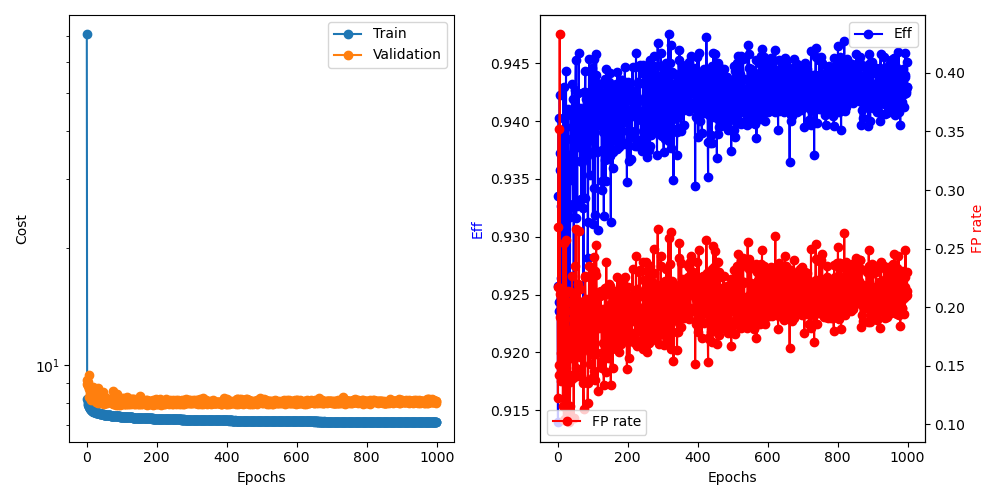

In [12]:
print('for model: ', model)   
run_name = 'UNet I'
# Create an mlflow run
with mlflow.start_run(run_name=run_name) as run:
    # Log parameters of the model
    for key, value in vars(args).items():
        print(key, value)
        mlflow.log_param(key, value)
    
    # Log parameter count in the model
    mlflow.log_param('Parameters', count_parameters(model))
    
    # Begin run
    for result in trainNet(model, optimizer, loss,
                            train_loader, val_loader,
                            args.epochs+args.epoch_start, epoch_start=args.epoch_start,
                            notebook=True, device=device):

        result = result._asdict()
        results = results.append(pd.Series(result), ignore_index=True)
    
        xs = results.index
    
        # Update the plot above
        lines['train'].set_data(results.index,results.cost)
        lines['val'].set_data(results.index,results.val)
    
        #filter first cost epoch (can be really large)
        max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
        min_cost = min(min(results.cost), min(results.val))
    
        # The plot limits need updating too
        ax.set_ylim(min_cost*.9, max_cost*1.1)  
        ax.set_xlim(-.5, len(results.cost) - .5)
    
        replace_in_ax(lax, lines['eff'], xs, results['eff_val'].apply(lambda x: x.eff_rate))
        replace_in_ax(tax, lines['fp'], xs, results['eff_val'].apply(lambda x: x.fp_rate))
    
        # Redraw the figure
        fig.canvas.draw()
            
        ## MLFLOW ##
        # Log metrics
        mlflow.log_metric('Efficiency', result['eff_val'].eff_rate, result['epoch'])
        mlflow.log_metric('False Positive Rate',  result['eff_val'].fp_rate, result['epoch'])
        mlflow.log_metric('Validation Loss',  result['val'], result['epoch'])
        mlflow.log_metric('Training Loss',  result['cost'], result['epoch'])
            
        # Log tags
        mlflow.set_tag('Optimizer', 'Adam')
        mlflow.set_tag('Kernel size', 'Mixed')
        mlflow.set_tag('Skip connections', '3')
        mlflow.set_tag('Activation', 'Softplus')
        mlflow.set_tag('Mid Activation', 'Relu')
        mlflow.set_tag('Extra Data', 'False')

        # Save model state dictionary, optimizer state dictionary, and epoch number
        torch.save({
            'model':model.state_dict(),
            'optimizer':optimizer.state_dict(),
            'epoch':args.epochs+result['epoch']
            }, 'run_stats.pyt')
        # Save the run stats into mlflow
        mlflow.log_artifact('run_stats.pyt')
            
        # Save a diagram of the architecture
#        HL.transforms.Fold("Conv", "Conv"),
#        HL.build_graph(model, torch.zeros([args.batch_size, 1, 4000]).to(device)).save('architecture', format='png')
#        mlflow.log_artifact('architecture.png')
        
        # log the code for the model architecture
#        mlflow.log_artifact('architecture.txt')
        
    dual_train_plots(results.index,
                 results.cost, results.val, 
                 results['eff_val'].apply(lambda x: x.eff_rate),
                 results['eff_val'].apply(lambda x: x.fp_rate))
    # save plot
    plt.tight_layout()
    plt.savefig('plot.png')
    mlflow.log_artifact('plot.png')

In [13]:
##quit()